# Прогнозирование температуры стали для оптимизации энергопотребления

**Цель проекта**  
Металлургический комбинат «Стальная птица» стремится сократить производственные расходы за счёт снижения потребления электроэнергии на этапе обработки стали. Для этого требуется точный контроль температуры сплава. Основная задача — разработка модели машинного обучения, способной прогнозировать температуру стали в реальном времени, что позволит оптимизировать технологический процесс и минимизировать энергозатраты.  

**Технологический процесс обработки стали**  
1. **Подготовка ковша**:  
   - Сталь плавится в ковше ёмкостью 100 тонн, облицованном огнеупорным кирпичом.  
   - Нагрев осуществляется графитовыми электродами, установленными в крышке ковша.  

2. **Десульфурация и корректировка состава**:  
   - Из сплава удаляется сера, после чего вводятся легирующие добавки для изменения химического состава.  
   - Добавки подаются через бункер для сыпучих материалов или трайб-аппарат (проволока).  

3. **Цикл измерений и легирования**:  
   - Перед первым введением добавок измеряются температура и химический состав стали.  
   - Далее цикл повторяется: нагрев → легирование → продувка инертным газом → перемешивание → замеры.  
   - Процесс продолжается до достижения целевых параметров температуры и состава.  

4. **Завершение обработки**:  
   - Готовая сталь отправляется на доводку или в машину непрерывной разливки для формирования слябов.  


**Подход к решению**  
1. **Анализ данных**: Выявление взаимосвязей между параметрами, обработка шумов и пропусков.  
2. **Генерация признаков**: Создание и отбор признаков, отражающих динамику процесса.  
3. **Выбор модели**:  
   - Регрессионные модели, обучение с учителем (LinearRegression, DecisionTreeRegressor, CatBoost) для интерпретируемости.   
4. **Валидация**: Метрики качества (MAE < 6.8) и тестирование на исторических данных.  


**Ожидаемый результат**  
Модель позволит:   
- Уменьшить количество циклов обработки, сократив время производства.  
- Предотвратить перегрев или недогрев сплава, улучшив качество продукции.  

**Итог**  
Проект направлен на цифровизацию ключевого этапа металлургического производства. Внедрение модели прогнозирования температуры станет шагом к снижению энергозатрат, т.е. себестоимости производства, а также станет шагом к «зелёной» металлургии, снижая углеродный след предприятия за счёт рационального использования ресурсов.

<a id='content'></a>   

<h1>Содержание</h1>
<ul>
<li><a href="#data-loading">Загрузка данных</a>
<ul>
<li><a href="#loading-arc">arc - данные об электродах</a></li>
<li><a href="#loading-bulk">bulk - данные о подаче сыпучих материалов (объём)</a></li> 
<li><a href="#loading-bulktime">bulk_time - данные о подаче сыпучих материалов (время)</a></li> 
<li><a href="#loading-gas">gas - данные о продувке сплава газом</a></li> 
<li><a href="#loading-temp">temp - результаты измерения температуры</a></li> 
<li><a href="#loading-wire">wire - данные о проволочных материалах (объём)</a></li> 
<li><a href="#loading-wiretime">wire_time - данные о проволочных материалах (время)</a></li> 
</ul>
</li>
<li><a href="#eda-preprocessing">Исследовательский анализ и предобработка данных</a>
<ul>
<li><a href="#arc_preproc">arc</a></li> 
<li><a href="#bulk_preproc">bulk</a></li> 
<li><a href="#bulk_time_preproc">bulk_time</a></li> 
<li><a href="#gas_preproc">gas</a></li> 
<li><a href="#temp_preproc">temp</a></li> 
<li><a href="#wire_preproc">wire</a></li> 
<li><a href="#wire_time_preproc">wire_time</a></li> 
</ul>
</li>
<li><a href="#data-merging">Объединение данных</a></li>
<li><a href="#merged-eda-preprocessing">Исследовательский анализ и предобработка данных объединённого датафрейма</a></li>
<li><a href="#data-preparation">Подготовка данных</a></li>
<li><a href="#model-training">Обучение моделей машинного обучения и выбор лучшей</a></li>
<ul>
<li><a href="#model-lr">Линейная регрессия</a></li> 
<li><a href="#model-tree">Ансамбль деревьев</a></li> 
<li><a href="#model-catboost">Catboost</a></li> 
</ul>
<li><a href="#model-selection">Предсказание на тестовой выборке, анализ важности признаков</a></li>
<li><a href="#conclusion-recommendations">Общий вывод и рекомендации заказчику</a></li>
</ul>

<h2 id="data-loading">Загрузка данных</h2>


In [1]:
!pip install pandas==2.2.2 seaborn==0.13.2 numba==0.60.0 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.


In [2]:
!pip install numpy==1.26.4 matplotlib==3.9.0 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.


In [3]:
!pip install --upgrade scikit-learn==1.2.2 jinja2==3.1.2 -q

In [4]:
!pip install shap -q

In [7]:
#Загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import warnings
import sklearn
import math
import re
from phik.phik import phik_matrix
from phik.report import plot_correlation_matrix
from numpy import mean
from numpy import std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import shap

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

pd.set_option("display.max_rows", None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [8]:
pantone_colors = {    
    "Greenery": "#88B04B",        
    "Ultra Violet": "#5F4B8B",    
    "Living Coral": "#FF6F61",    
    "Classic Blue": "#4F7DA1",    
    "Serenity": "#92A8D1",        
    "Very Peri": "#6667AB",        
    "Viva Magenta": "#BB2649",    
    "Peach Fuzz": "#F7D2C5",      
    "Lush Green": "#1E5B4F"       
}

In [9]:
# Функция для построения гистограмм
def plot_histograms(df, 
                    columns, 
                    rows=2, 
                    color=pantone_colors['Classic Blue']):
    """
    Строит гистограммы для указанных числовых столбцов в DataFrame.

    Args:
        df: DataFrame с данными.
        columns: Список названий числовых столбцов.
        rows: Количество рядов в сетке графиков.
    """
    num_plots = len(columns)
    cols = num_plots // rows + (num_plots % rows > 0)  
    fig, axes = plt.subplots(nrows=rows, 
                             ncols=cols, 
                             figsize=(cols*5, rows*4))
    axes = axes.flatten()  

    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, ax=axes[i],
                     kde=True, 
                    color=color, 
                    stat='probability')
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()


#Функция для загрузки дата сета, 
#file_name - строка с названием файла для загрузки, 
#df_name - название для загружаемого датасета
#sep - разделитель, по умолчанию ','
#graf - строим ли графики

def loading_data(file_name, df_name, sep=',', graf=True, missingno=False, 
                 num_columns=3, figsize=(15,10), bins=30, 
                 color=pantone_colors['Classic Blue']):
    
    try:
        df = pd.read_csv('assets/'+  file_name, sep=sep) 
    except:
        df = pd.read_csv('/datasets/' + file_name, sep=sep) 
    
    pd.set_option("display.max_columns", None)
    
    print(df_name)
    display(df.head(5))
    print('-'*80)
    print('Общая информация о наборе данных, индекс, ',
          'столбцы и тип данных, нулевые значения и использование памяти ')
    print()
    print(df.info())
    print('-'*80)
    print('Оценим количество пропущенных значений в каждом столбце, в %')
    print()
    display(pd.DataFrame(df.isna().mean()*100)
            .style.format("{:.2f}").background_gradient('coolwarm'))
    #display(df.isna().sum())
    
    if missingno == True:
        print('-'*80)
        print('Визуализируем пропуски в данных')
        msno.matrix(df, figsize = (10,8))
    if graf == True:
        plt.show()
        print('-'*80)
        print('Визуализируем общие данные')
        if 'key' in df.columns:
            df_new = df.drop(columns=['key'])
        else:
            df_new = df

        # Вызываем функцию, указав желаемое количество рядов
        numeric_cols = df_new.select_dtypes(include=['number']).columns
        rows = math.ceil(len(numeric_cols)/num_columns)
        plot_histograms(df_new, numeric_cols, rows=rows, color=color)  
        
        #g.fig.set_size_inches(figsize)
        
        plt.show()
        #label = 'Гистограмма распределения '+ my_title
        #plt.title(label=label, fontsize = 24, y = 1, color = 'midnightblue')  
        #sns.set_context(rc={'legend.fontsize': 24})
          

    return df

 <h3 id="loading-arc">arc - данные об электродах</h3>

arc


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце, в %



,0
key,0.00
Начало нагрева дугой,0.00
Конец нагрева дугой,0.00
Активная мощность,0.00
Реактивная мощность,0.00


--------------------------------------------------------------------------------
Визуализируем общие данные


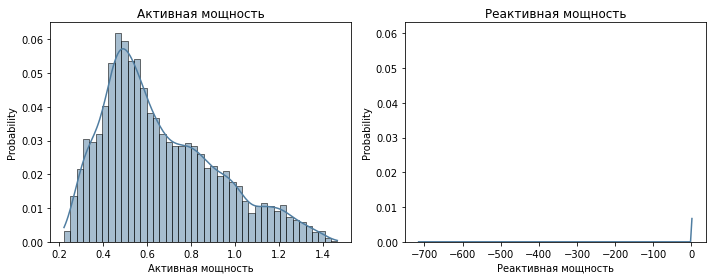

In [10]:
arc = loading_data('data_arc_new.csv', 'arc')

<a id='link-1'></a>

In [11]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [12]:
arc = arc.rename(columns={'Конец нагрева дугой':'end_heating',
                    'Начало нагрева дугой': 'start_heating',
                    'Активная мощность':'active_power', 
                    'Реактивная мощность': 'reactive_power'})

In [13]:
arc['end_heating'] = pd.to_datetime(arc['end_heating'])
arc['start_heating'] = pd.to_datetime(arc['start_heating'])

In [14]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   end_heating     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [15]:
arc.head(7)

,key,start_heating,end_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527


**Выводы по датафрейму arc**
- Гистограмма распределения реактивной мощности показывает наличие выбросов.(отрицательные значения)
- Гистограмма распределения активной мощности похожа на нормальное распределение (симметричная форма, пик в центре, хвосты затухают постепенно, как это свойственно нормальному распределению.)
- В зависимости от партии имеем в среднем 4-5 записей (циклов нагрев → легирование  → перемешивание → замеры.).
- Пропуски в данных отсутсвуют.


- Названия столбцов приведены к стандарту snake_case
- Столбцы, содержащие время, приведены к формату datetime.


<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="loading-bulk">bulk - данные о подаче сыпучих материалов (объём)</h3>

bulk


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), i

,0
key,0.00
Bulk 1,91.95
Bulk 2,99.30
Bulk 3,58.52
Bulk 4,67.59
Bulk 5,97.54
Bulk 6,81.59
Bulk 7,99.20
Bulk 8,99.97
Bulk 9,99.39


--------------------------------------------------------------------------------
Визуализируем общие данные


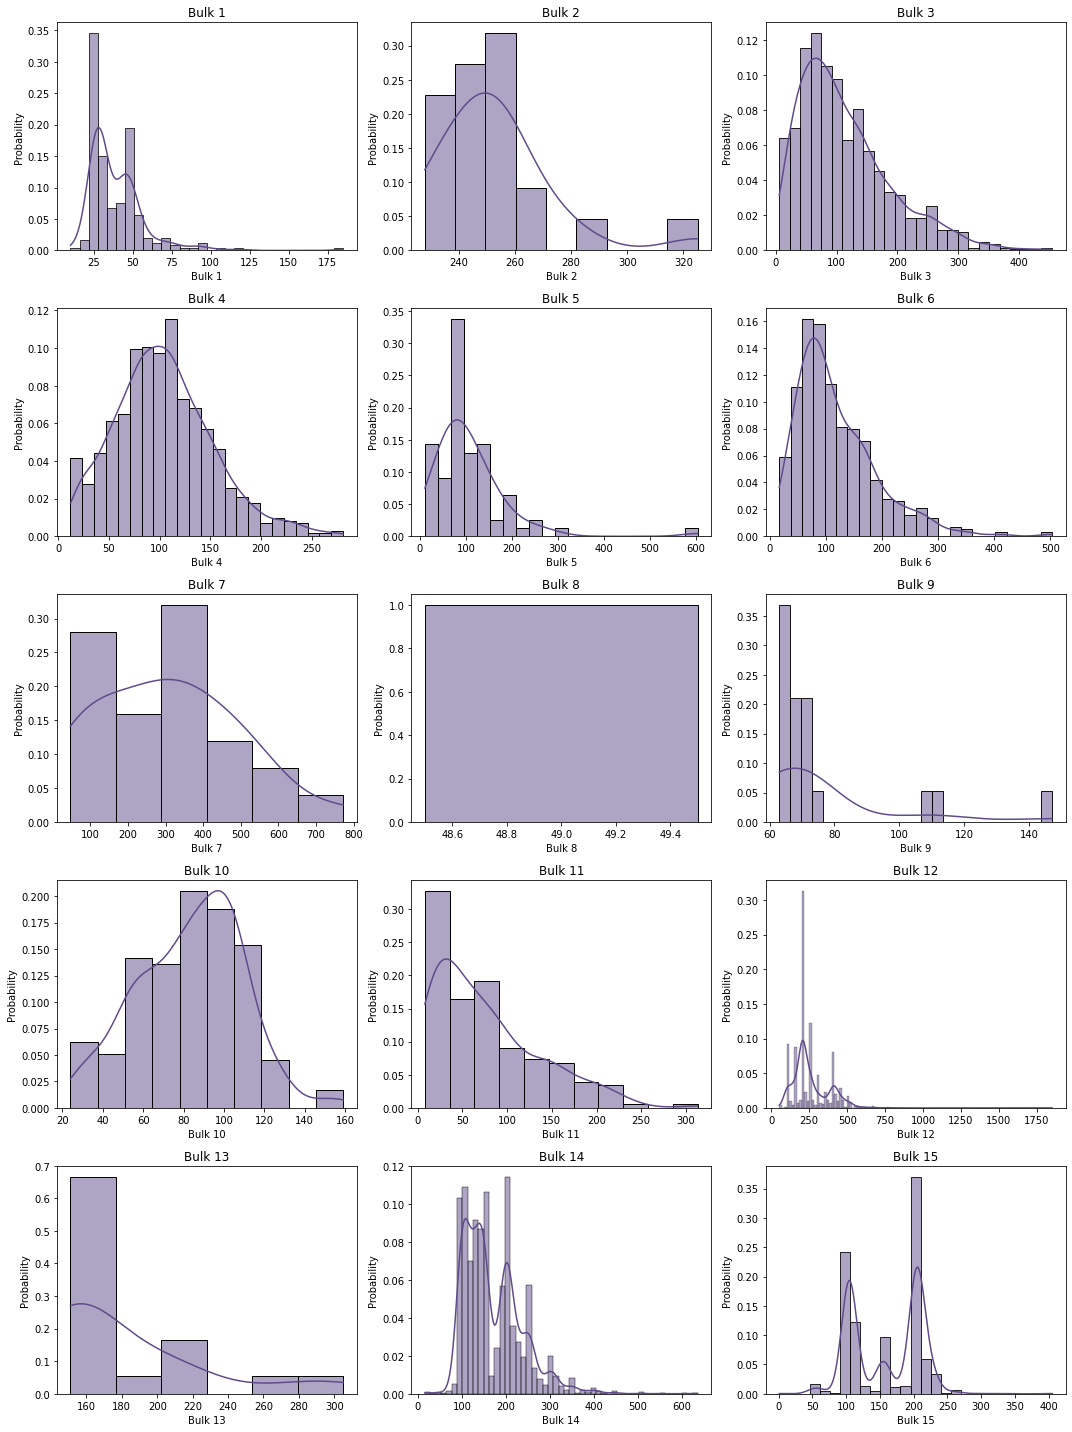

In [16]:
bulk = loading_data('data_bulk_new.csv', 
                    'bulk', 
                    color=pantone_colors['Ultra Violet'])

<a href="#go-back-bulk">Перейти к исследованию и заполнению пропусков в bulk</p>
<p id="go-bulk"></p>



In [17]:
bulk.columns = [
    re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() 
    for i in bulk.columns
]

In [18]:
bulk_stat = bulk.describe()
bulk_stat

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


**Выводы по датафрейму bulk**

В таблице представлен объем сыпучих материалов, которые добавляют в справ во время легирования.
- Состав сыпучих добавок закодирован номерами 1-15. 
- Более редкие добавки под номерами - 8, 13, 2, 7, 5 в порядке увеличеня частоты использования (применялись менее чем в 100 партиях)
- В данных присутсвует много пропусков (NaN), что свидетельсвует о том, что данный материал не добавлялся в сплав в конкретной партии. Данные пропуски будут заполнены нулями.
- Названия столбцов приведены к стандарту snake_case

<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="loading-bulktime">bulk_time - данные о подаче сыпучих материалов (время)</h3>

In [19]:
bulk_time = loading_data('data_bulk_time_new.csv', 'bulk_time', graf=False)

bulk_time


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usag

,0
key,0.00
Bulk 1,91.95
Bulk 2,99.30
Bulk 3,58.52
Bulk 4,67.59
Bulk 5,97.54
Bulk 6,81.59
Bulk 7,99.20
Bulk 8,99.97
Bulk 9,99.39


In [20]:
exclude_column = 'key'

for col in bulk_time.columns:
    if col != exclude_column:
        bulk_time[col] = pd.to_datetime(bulk_time[col])
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [21]:
bulk_time.columns = [
    re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() 
    for i in bulk.columns
]

In [22]:
bulk_time.head(7)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaT,NaT,NaT,2019-05-03 13:57:27,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:48:52,NaT,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaT,NaT,NaT,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:41:26,NaT,2019-05-03 14:30:50,2019-05-03 14:27:16


**Выводы по датафрейму bulk_time**

- Датафрейм содержит данные о времени добавления сыпучих материалов из датафрейма bulk. Сравнивая количество записейв  bulk_time и bulk можно сделать вывод о том, что для каждого добавления есть время.
- Названия столбцов приведены к стандарту snake_case, тип данных времени datetime

<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="loading-gas">gas - данные о продувке сплава газом</h3>

In [23]:
gas = loading_data('data_gas_new.csv', 'gas', graf=False)

gas


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце, в %



,0
key,0.00
Газ 1,0.00


In [24]:
gas = gas.rename(columns={'Газ 1': 'gas'})

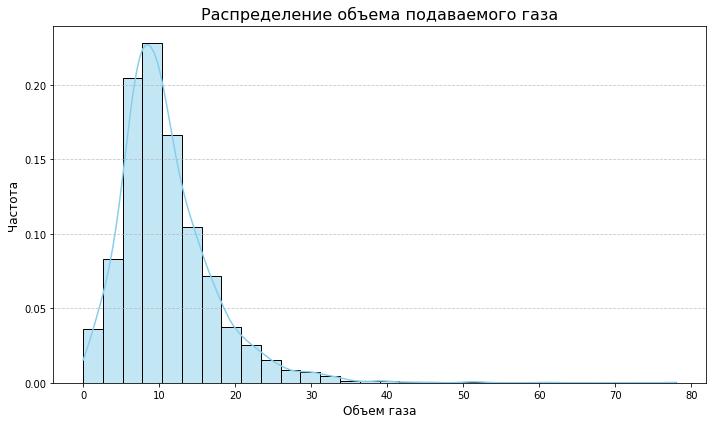

In [25]:
plt.figure(figsize=(10, 6))  
sns.histplot(gas, x='gas', 
             bins=30, 
             kde=True, 
             color='skyblue', 
             stat='probability') 
plt.title('Распределение объема подаваемого газа', fontsize=16)  
plt.xlabel('Объем газа', fontsize=12)  
plt.ylabel('Частота', fontsize=12)  
# Настройка сетки для лучшей читаемости
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

In [26]:
gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


**Выводы по датасету gas:**
- Пропуски отсутсвуют
- Гистограмма показывает унимодальное распределение с модой около 10.
- Правосторонняя асимметрия (правый хвост длинный и растянутый, включает редкие события с высокими значениями объема газа, от 35 до 80)
- Название столбца приведено к стандарту snake_case


<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="loading-temp">temp - результаты измерения температуры</h3>

In [27]:
temp = loading_data('data_temp_new.csv', 'temp', graf=False)

temp


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце, в %



,0
key,0.00
Время замера,0.00
Температура,18.94


In [28]:
temp = temp.rename(columns={'Время замера': 'measurement_time',
                            'Температура': 'temperature'})

In [29]:
temp['measurement_time'] = pd.to_datetime(temp['measurement_time'])

In [30]:
temp.describe()

,key,measurement_time,temperature
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


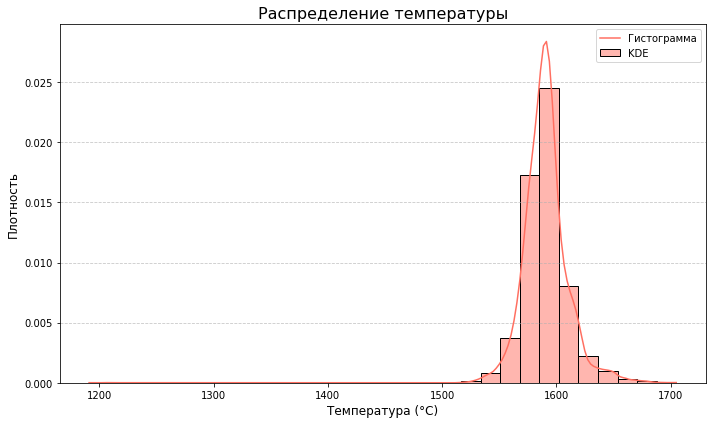

In [31]:
plt.figure(figsize=(10, 6)) 
sns.histplot(
    temp, 
    x='temperature', 
    bins=30, 
    kde=True,  
    color=pantone_colors['Living Coral'], 
    edgecolor='black', 
    stat='density'  
)

plt.title('Распределение температуры', fontsize=16)
plt.xlabel('Температура (°C)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(labels=['Гистограмма', 'KDE'], loc='upper right')
plt.tight_layout() 
plt.show()

**Выводы по датасету temp**
- Большое количество пропусков в столбце со значением температуры (почти 19%)
- Есть выбросы  (минимальное значение 1191°C, при этом температура плавления стали 1400°C)
- Названия столбцов приведены к стандарту snake_case
- Время приведено к типу datetime

<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="loading-wire">wire - данные о проволочных материалах (объём)</h3>

wire


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце, в %



,0
key,0.00
Wire 1,0.84
Wire 2,64.98
Wire 3,97.96
Wire 4,99.55
Wire 5,99.97
Wire 6,97.63
Wire 7,99.64
Wire 8,99.38
Wire 9,99.06


--------------------------------------------------------------------------------
Визуализируем общие данные


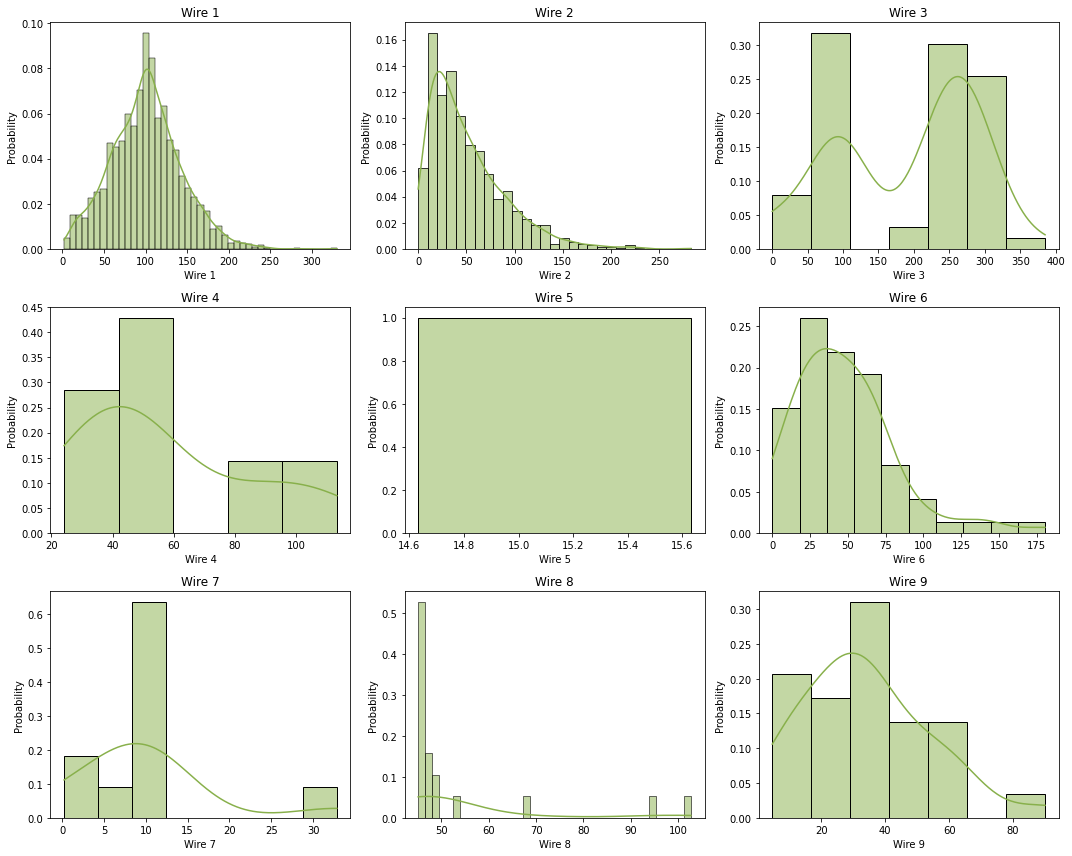

In [32]:
wire = loading_data('data_wire_new.csv', 
                    'wire', 
                    color=pantone_colors['Greenery'])

In [33]:
wire.columns = [
    re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() 
    for i in wire.columns
]

In [34]:
wire_stat = wire.describe()
wire_stat

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


**Выводы по датафрейму wire**

В таблице представлен объем проволочных материалов, которые добавляют в справ во время легирования.
- Состав проволочных добавок закодирован номерами 1-9. 
- Более редкие добавки под номерами - 5, 7, 4, 8, 9, 3, 6 в порядке увеличеня частоты использования (применялись менее чем в 100 партиях)
- В данных присутсвует много пропусков (NaN), что свидетельсвует о том, что данный материал не добавлялся в сплав в конкретной партии. Данные пропуски будут заполнены нулями.
- Названия столбцов приведены к стандарту snake_case

<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="loading-wiretime">wire_time - данные о проволочных материалах (время)</h3>

In [35]:
wire_time = loading_data('data_wire_time_new.csv', 'wire_time', graf=False)

wire_time


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце, в %



,0
key,0.00
Wire 1,0.84
Wire 2,64.98
Wire 3,97.96
Wire 4,99.55
Wire 5,99.97
Wire 6,97.63
Wire 7,99.64
Wire 8,99.38
Wire 9,99.06


In [36]:
wire_time.columns = [
    re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() 
    for i in wire_time.columns
]

In [37]:
wire_time.head(7)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
exclude_column = 'key'

for col in wire_time.columns:
    if col != exclude_column:
        wire_time[col] = pd.to_datetime(wire_time[col])
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


**Выводы по датафрейму wire_time**

- Датафрейм содержит данные о времени добавления проволочных материалов из датафрейма wire. Сравнивая количество записейв  wire_time и wire можно сделать вывод о том, что для каждого добавления есть время.
- Названия столбцов приведены к стандарту snake_case, тип данных времени datetime

<a href='#content'>Вернуться к оглавлению</a> 

<h2 id="eda-preprocessing">Исследовательский анализ и предобработка данных</h2>


<h3 id="arc_preproc">arc</h3>

In [39]:
arc.head(7)

,key,start_heating,end_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527


<a href='#link-1'>Во время знакомства с данными были обнаружены единичные выбросы в столбце reactive_power</a> 

In [40]:
arc.loc[arc['reactive_power']<0]

,key,start_heating,end_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Это едниничное значение, удалим его из датасета.

In [41]:
print('Размер датасета до удаления выброса:', arc.shape)
arc = arc.loc[~(arc['reactive_power'] < 0)]
print('Размер датасета после удаления выброса:', arc.shape)

Размер датасета до удаления выброса: (14876, 5)
Размер датасета после удаления выброса: (14875, 5)


Добавим к данным столбец с длительностью нагрева, полную мощность и работу, совершенную для нагрева.

<p>Активная (P) и реактивная (Q) мощности — это две составляющие полной мощности (S) в цепях переменного тока.</p>
<div><b>
  S<sup>2</sup> = P<sup>2</sup> + Q<sup>2</sup></b>
</div>
<p>Работа вычисляется по формуле: </p>
<div><b>
A = P⋅t
</b></div>
где:
<p>A — работа,(в МДж)</p>
<p>P — активная мощность,(в МВт)</p>
<p>t — время (в секундах, с).</p>

In [42]:
# высчитываем длительность
arc['duration'] = (arc['end_heating'] - 
                   arc['start_heating']).dt.total_seconds()
# считаем полную мощность
arc['full_power'] = (arc['active_power']**2 + arc['reactive_power']**2)**0.5
# вычисляем работу
arc['work'] = arc['full_power']*arc['duration']
arc.head(10)

,key,start_heating,end_heating,active_power,reactive_power,duration,full_power,work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,0.440239,60.312695
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0,0.332731,112.463079
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0,0.860064,108.368056
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0,0.955315,200.616176
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0,1.373863,384.681584


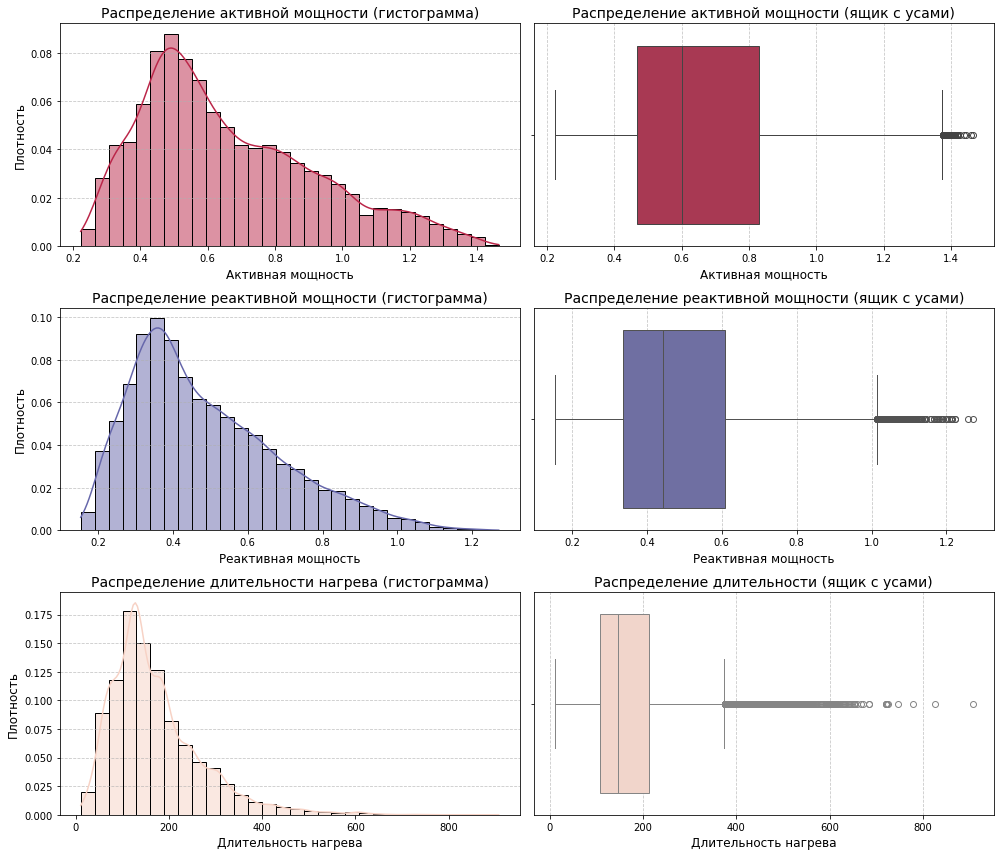

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12)) 

# Гистограмма активной мощности
sns.histplot(
    arc, 
    x='active_power', 
    bins=30, 
    kde=True, 
    color=pantone_colors['Viva Magenta'], 
    edgecolor='black', 
    ax=axes[0,0],  
    stat='probability'
)
axes[0,0].set_title('Распределение активной мощности (гистограмма)', 
                    fontsize=14)
axes[0,0].set_xlabel('Активная мощность', fontsize=12)
axes[0,0].set_ylabel('Плотность', fontsize=12)
axes[0,0].grid(axis='y', linestyle='--', alpha=0.7)

# Ящик с усами для активной мощности
sns.boxplot(
    data=arc, 
    x='active_power', 
    color=pantone_colors['Viva Magenta'], 
    ax=axes[0,1]
)
axes[0,1].set_title('Распределение активной мощности (ящик с усами)', 
                    fontsize=14)
axes[0,1].set_xlabel('Активная мощность', fontsize=12)
axes[0,1].grid(axis='x', linestyle='--', alpha=0.7) 

# Гистограмма реактивной мощности
sns.histplot(
    arc, 
    x='reactive_power', 
    bins=30, 
    kde=True, 
    color=pantone_colors['Very Peri'], 
    edgecolor='black', 
    ax=axes[1,0],  
    stat='probability'
)
axes[1,0].set_title('Распределение реактивной мощности (гистограмма)', 
                    fontsize=14)
axes[1,0].set_xlabel('Реактивная мощность', fontsize=12)
axes[1,0].set_ylabel('Плотность', fontsize=12)
axes[1,0].grid(axis='y', linestyle='--', alpha=0.7)

# Ящик с усами для реактивной мощности
sns.boxplot(
    data=arc, 
    x='reactive_power', 
    color=pantone_colors['Very Peri'], 
    ax=axes[1,1]
)
axes[1,1].set_title('Распределение реактивной мощности (ящик с усами)', 
                    fontsize=14)
axes[1,1].set_xlabel('Реактивная мощность', fontsize=12)
axes[1,1].grid(axis='x', linestyle='--', alpha=0.7) 

# Гистограмма длительности нагрева
sns.histplot(
    arc, 
    x='duration', 
    bins=30, 
    kde=True, 
    color=pantone_colors['Peach Fuzz'], 
    edgecolor='black', 
    ax=axes[2,0],  
    stat='probability'
)
axes[2,0].set_title('Распределение длительности нагрева (гистограмма)', 
                    fontsize=14)
axes[2,0].set_xlabel('Длительность нагрева', fontsize=12)
axes[2,0].set_ylabel('Плотность', fontsize=12)
axes[2,0].grid(axis='y', linestyle='--', alpha=0.7)

# Ящик с усами для длительности нагрева
sns.boxplot(
    data=arc, 
    x='duration', 
    color=pantone_colors['Peach Fuzz'], 
    ax=axes[2,1]
)
axes[2,1].set_title('Распределение длительности (ящик с усами)', 
                    fontsize=14)
axes[2,1].set_xlabel('Длительность нагрева', fontsize=12)
axes[2,1].grid(axis='x', linestyle='--', alpha=0.7) 

plt.tight_layout()
plt.show()

**Анализ графиков**

- Все гистограммы имеют один пик, 
- общая форма напоминает нормальное распределение, но с ассиметрией: правый хвост длинее, что указывает на наличие редких высоких значений.
- На всех ящиках с усами наблюдаются статистические выбросы: значения за пределами усов. 
- На практике данные значения не считаются ошибочными, встречаются при производстве, поэтому не требуют очистки.  

Преобразуем данные:

1. Удаляем столбцы с временем начала и окончания нагрева, оставляя только длительность в секундах, так как для решения задачи важна лишь продолжительность процессов.
2. Цель исследования — предсказание температуры ковша в конце цикла. Поэтому промежуточные этапы рассматриваем как единый процесс, суммируя затраты энергии и время.

In [44]:
arc_sum = arc.copy()

In [45]:
arc_sum = arc.drop(columns=['start_heating','end_heating'])
arc_sum =arc_sum .groupby('key').sum().reset_index()
arc_sum.head(10)

,key,active_power,reactive_power,duration,full_power,work
0,1,3.036730,2.142821,1098.0,3.718736,770.282114
1,2,2.139408,1.453357,811.0,2.588349,481.760005
2,3,4.063641,2.937457,655.0,5.019223,722.837668
3,4,2.706489,2.056992,741.0,3.400038,683.455597
4,5,2.252950,1.687991,869.0,2.816980,512.169934
5,6,2.725274,1.881313,952.0,3.313074,839.231310
6,7,2.626877,1.960419,673.0,3.283913,613.576982
7,8,2.678958,2.096952,913.0,3.405956,619.129542
8,9,3.520820,2.527365,625.0,4.335261,570.113675
9,10,3.118778,2.154941,825.0,3.791005,533.482050


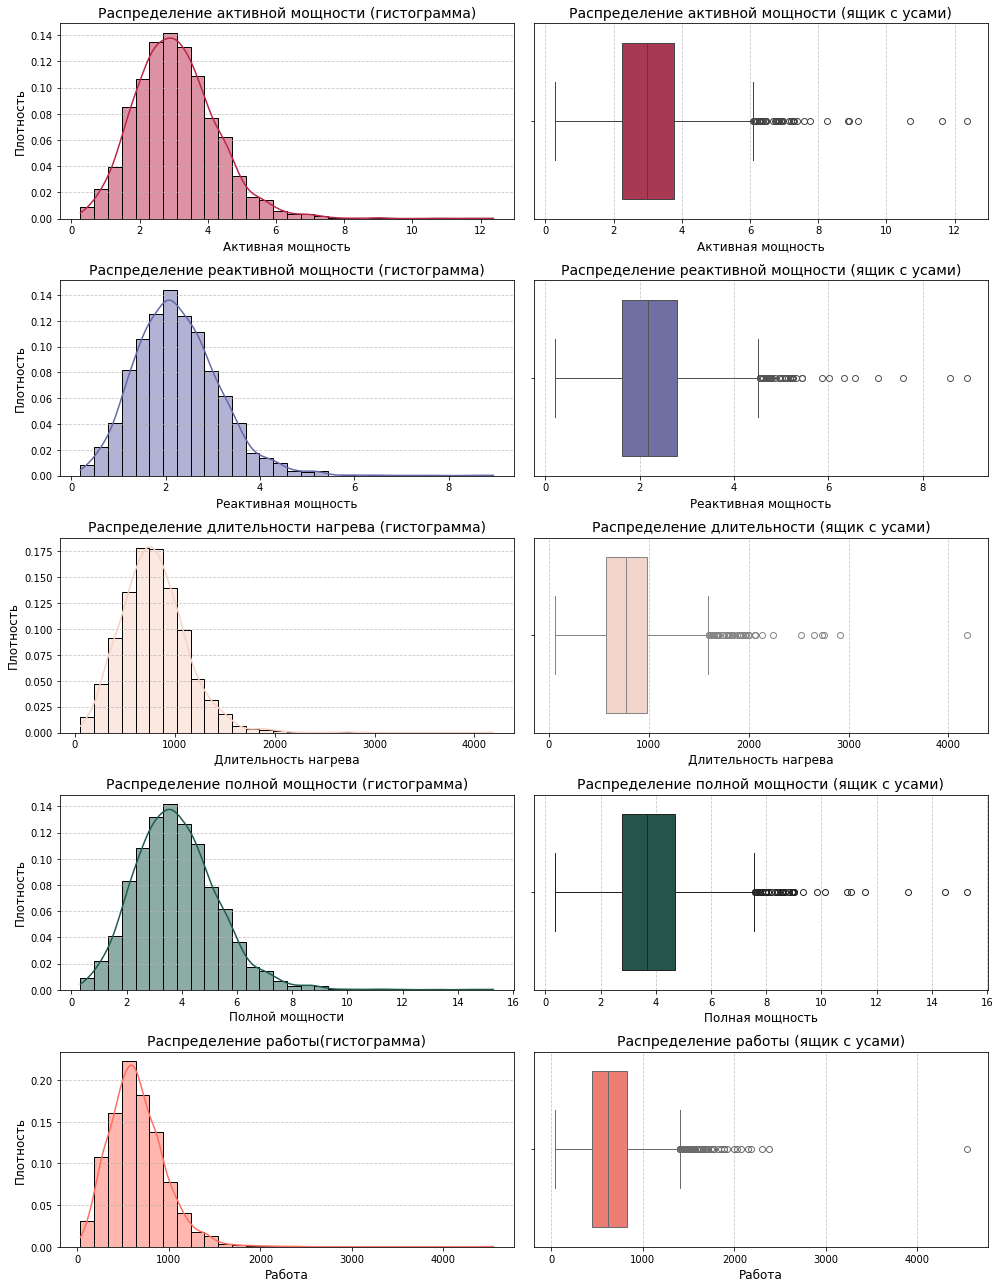

In [46]:
fig, axes = plt.subplots(5, 2, figsize=(14, 18)) 

# Гистограмма активной мощности
sns.histplot(
    arc_sum, 
    x='active_power', 
    bins=30, 
    kde=True, 
    color=pantone_colors['Viva Magenta'], 
    edgecolor='black', 
    ax=axes[0,0],  
    stat='probability'
)
axes[0,0].set_title('Распределение активной мощности (гистограмма)', 
                    fontsize=14)
axes[0,0].set_xlabel('Активная мощность', fontsize=12)
axes[0,0].set_ylabel('Плотность', fontsize=12)
axes[0,0].grid(axis='y', linestyle='--', alpha=0.7)

# Ящик с усами для активной мощности
sns.boxplot(
    data=arc_sum, 
    x='active_power', 
    color=pantone_colors['Viva Magenta'], 
    ax=axes[0,1]
)
axes[0,1].set_title('Распределение активной мощности (ящик с усами)', 
                    fontsize=14)
axes[0,1].set_xlabel('Активная мощность', fontsize=12)
axes[0,1].grid(axis='x', linestyle='--', alpha=0.7) 

# Гистограмма реактивной мощности
sns.histplot(
    arc_sum, 
    x='reactive_power', 
    bins=30, 
    kde=True, 
    color=pantone_colors['Very Peri'], 
    edgecolor='black', 
    ax=axes[1,0],  
    stat='probability'
)
axes[1,0].set_title('Распределение реактивной мощности (гистограмма)', 
                    fontsize=14)
axes[1,0].set_xlabel('Реактивная мощность', fontsize=12)
axes[1,0].set_ylabel('Плотность', fontsize=12)
axes[1,0].grid(axis='y', linestyle='--', alpha=0.7)

# Ящик с усами для реактивной мощности
sns.boxplot(
    data=arc_sum, 
    x='reactive_power', 
    color=pantone_colors['Very Peri'], 
    ax=axes[1,1]
)
axes[1,1].set_title('Распределение реактивной мощности (ящик с усами)', 
                    fontsize=14)
axes[1,1].set_xlabel('Реактивная мощность', fontsize=12)
axes[1,1].grid(axis='x', linestyle='--', alpha=0.7) 

# Гистограмма длительности нагрева
sns.histplot(
    arc_sum, 
    x='duration', 
    bins=30, 
    kde=True, 
    color=pantone_colors['Peach Fuzz'], 
    edgecolor='black', 
    ax=axes[2,0],  
    stat='probability'
)
axes[2,0].set_title('Распределение длительности нагрева (гистограмма)', 
                    fontsize=14)
axes[2,0].set_xlabel('Длительность нагрева', fontsize=12)
axes[2,0].set_ylabel('Плотность', fontsize=12)
axes[2,0].grid(axis='y', linestyle='--', alpha=0.7)

# Ящик с усами для длительности нагрева
sns.boxplot(
    data=arc_sum, 
    x='duration', 
    color=pantone_colors['Peach Fuzz'], 
    ax=axes[2,1]
)
axes[2,1].set_title('Распределение длительности (ящик с усами)', 
                    fontsize=14)
axes[2,1].set_xlabel('Длительность нагрева', fontsize=12)
axes[2,1].grid(axis='x', linestyle='--', alpha=0.7) 

# Гистограмма полной мощности
sns.histplot(
    arc_sum, 
    x='full_power', 
    bins=30, 
    kde=True, 
    color=pantone_colors['Lush Green'], 
    edgecolor='black', 
    ax=axes[3,0],  
    stat='probability'
)
axes[3,0].set_title('Распределение полной мощности (гистограмма)', 
                    fontsize=14)
axes[3,0].set_xlabel('Полной мощности', fontsize=12)
axes[3,0].set_ylabel('Плотность', fontsize=12)
axes[3,0].grid(axis='y', linestyle='--', alpha=0.7)

# Ящик с усами для полной мощности
sns.boxplot(
    data=arc_sum, 
    x='full_power', 
    color=pantone_colors['Lush Green'], 
    ax=axes[3,1]
)
axes[3,1].set_title('Распределение полной мощности (ящик с усами)', 
                    fontsize=14)
axes[3,1].set_xlabel('Полная мощность', fontsize=12)
axes[3,1].grid(axis='x', linestyle='--', alpha=0.7) 

# Гистограмма работы
sns.histplot(
    arc_sum, 
    x='work', 
    bins=30, 
    kde=True, 
    color=pantone_colors['Living Coral'], 
    edgecolor='black', 
    ax=axes[4,0],  
    stat='probability'
)
axes[4,0].set_title('Распределение работы(гистограмма)', 
                    fontsize=14)
axes[4,0].set_xlabel('Работа', fontsize=12)
axes[4,0].set_ylabel('Плотность', fontsize=12)
axes[4,0].grid(axis='y', linestyle='--', alpha=0.7)

# Ящик с усами для полной мощности
sns.boxplot(
    data=arc_sum, 
    x='work', 
    color=pantone_colors['Living Coral'], 
    ax=axes[4,1]
)
axes[4,1].set_title('Распределение работы (ящик с усами)', fontsize=14)
axes[4,1].set_xlabel('Работа', fontsize=12)
axes[4,1].grid(axis='x', linestyle='--', alpha=0.7) 

plt.tight_layout()
plt.show()

**Анализ графиков**

После суммирования данных по ковшу форма гистограмм осталась проежней: распределение напоминает нормальное, но с явной правосторонней асимметрией.
Данная ассиметрия стала более выраженой, это подтверждает и ящик с усами. Выделяется порядка 7 отдельных аномальных значений, которые могут в дальнейшем мешать обучению моделей, чувствительных к выбросам.



In [47]:
arc_sum.describe()

,key,active_power,reactive_power,duration,full_power,work
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1623.061294,3.067329,2.254462,794.545115,3.810779,655.569107
std,934.739859,1.208697,0.894743,332.491076,1.502804,308.976732
min,1.000000,0.267676,0.196228,57.000000,0.331897,33.430208
25%,817.250000,2.235394,1.630658,571.000000,2.775306,444.626580
50%,1623.500000,2.984581,2.176833,770.000000,3.694219,620.101427
75%,2431.750000,3.775472,2.788330,983.000000,4.696915,827.671845
max,3241.000000,12.375636,8.949049,4189.000000,15.288271,4546.405812


**arc_sum**
- При нормализации и обучении моделей необходимо учесть, что в данных есть статистические выбросы, при этом данные значения свойственны реальному процессу.
- данные готовы для дальнейшей работы.

<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="bulk_preproc">bulk</h3>

In [48]:
bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [49]:
bulk_stat

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [50]:
bulk = bulk.fillna(0)
bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [51]:
bulk['bulk_total'] = bulk.sum(axis=1) - bulk['key']
bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_total
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


In [52]:
bulk = bulk.astype(int)
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   key         3129 non-null   int64
 1   bulk_1      3129 non-null   int64
 2   bulk_2      3129 non-null   int64
 3   bulk_3      3129 non-null   int64
 4   bulk_4      3129 non-null   int64
 5   bulk_5      3129 non-null   int64
 6   bulk_6      3129 non-null   int64
 7   bulk_7      3129 non-null   int64
 8   bulk_8      3129 non-null   int64
 9   bulk_9      3129 non-null   int64
 10  bulk_10     3129 non-null   int64
 11  bulk_11     3129 non-null   int64
 12  bulk_12     3129 non-null   int64
 13  bulk_13     3129 non-null   int64
 14  bulk_14     3129 non-null   int64
 15  bulk_15     3129 non-null   int64
 16  bulk_total  3129 non-null   int64
dtypes: int64(17)
memory usage: 415.7 KB


<p id="go-back-bulk"></p>
<a href="#go-bulk">Перейти к гистограммам bulk</a>

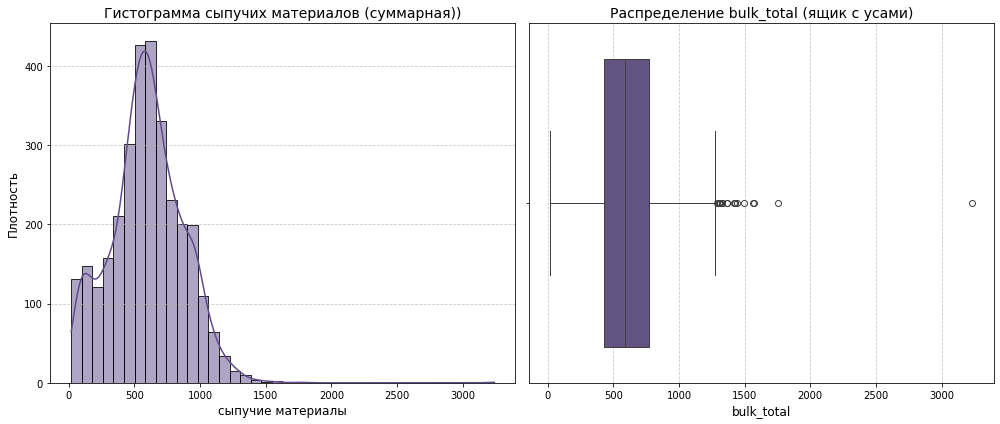

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
# Гистограмма bulk_total
sns.histplot(
    bulk, 
    x='bulk_total', 
    bins=40, 
    kde=True, 
    color=pantone_colors['Ultra Violet'], 
    edgecolor='black', 
    ax=axes[0] 
)
axes[0].set_title('Гистограмма сыпучих материалов (суммарная))', fontsize=14)
axes[0].set_xlabel('сыпучие материалы', fontsize=12)
axes[0].set_ylabel('Плотность', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем сетку

# Ящик с усами для bulk_total
sns.boxplot(
    data=bulk, 
    x='bulk_total', 
    color=pantone_colors['Ultra Violet'], 
    ax=axes[1] 
)
axes[1].set_title('Распределение bulk_total (ящик с усами)', fontsize=14)
axes[1].set_xlabel('bulk_total', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7) 

plt.tight_layout()
plt.show()

**Анализ графиков**
- Распределение имеет один пик (унимодальное).
- Общая форма напоминает нормальное распределение , но с легкой правосторонней асимметрией :
- Длинный правый хвост на гистограмме и данные за пределами усов ящика указывает на наличие редких высоких значений (аномалий)

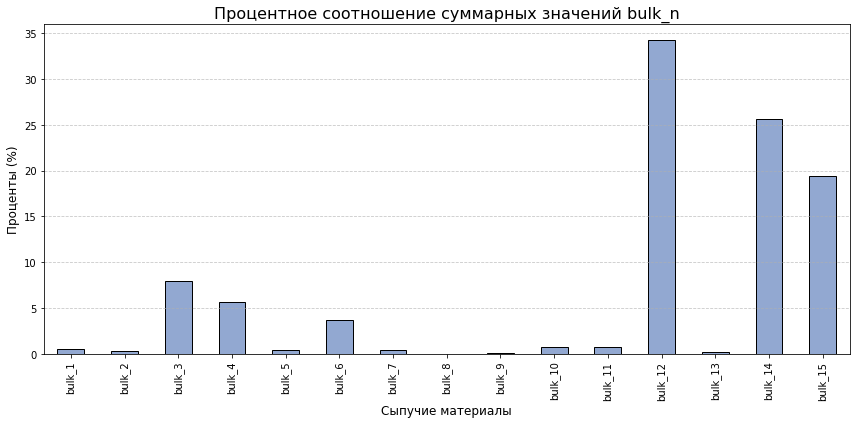

In [54]:
# Вычисление сумм для каждого bulk_n
sums = bulk.iloc[:, 1:-1].sum()
# Нормализация значений в проценты
percentages = sums / sums.sum() * 100

plt.figure(figsize=(12, 6))
percentages.plot(kind='bar', 
                color=pantone_colors['Serenity'],
                edgecolor='black')
plt.title('Процентное соотношение суммарных значений bulk_n', fontsize=16)
plt.xlabel('Сыпучие материалы', fontsize=12)
plt.ylabel('Проценты (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Вывод по датафрейму bulk:**

- Пропуски заполнены нулевыми значениями.
- Создан новый признак — сумма всех сыпучих материалов для каждой партии.
- Тип данных оптимизирован до целочисленного (int).

<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="bulk_time_preproc">bulk_time</h3>

In [55]:
bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [56]:
# Функция для замены времени на очередность
def replace_time_with_order(row):
    times = row.dropna().sort_values()
    time_to_order = {time: i + 1 for i, time in enumerate(times)}
    return row.map(time_to_order).fillna(0).astype(int)

# Применение функции к каждой строке
bulk_time.iloc[:, 1:] = bulk_time.iloc[:, 1:].apply(replace_time_with_order, 
                                                    axis=1)

bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,4,0,0,0,0,0,0,0,3,0,2,1
1,2,0,0,0,1,0,0,0,0,0,0,0,4,0,3,2
2,3,0,0,0,4,0,0,0,0,0,0,0,3,0,2,1
3,4,0,0,0,1,0,0,0,0,0,0,0,4,0,3,2
4,5,0,0,0,3,0,0,0,0,0,0,0,3,0,4,3


In [57]:
bulk_time.columns = ([bulk_time.columns[0]] + 
                     ['time_' + col for col in bulk_time.columns[1:]])


Добавим столбец с количеством добавок в сплаве

In [58]:
bulk_time['bulk_count'] = bulk_time.iloc[:, 1:].max(axis=1)
bulk_time.head()

,key,time_bulk_1,time_bulk_2,time_bulk_3,time_bulk_4,time_bulk_5,time_bulk_6,time_bulk_7,time_bulk_8,time_bulk_9,time_bulk_10,time_bulk_11,time_bulk_12,time_bulk_13,time_bulk_14,time_bulk_15,bulk_count
0,1,0,0,0,4,0,0,0,0,0,0,0,3,0,2,1,4
1,2,0,0,0,1,0,0,0,0,0,0,0,4,0,3,2,4
2,3,0,0,0,4,0,0,0,0,0,0,0,3,0,2,1,4
3,4,0,0,0,1,0,0,0,0,0,0,0,4,0,3,2,4
4,5,0,0,0,3,0,0,0,0,0,0,0,3,0,4,3,4


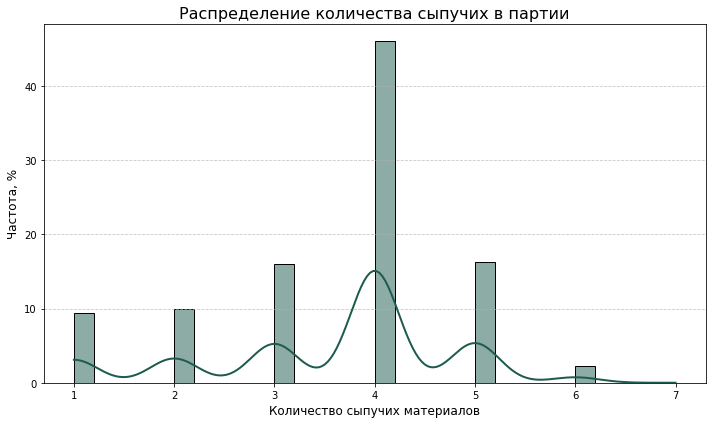

In [59]:
plt.figure(figsize=(10, 6))  
sns.histplot(
    data=bulk_time,
    x='bulk_count',
    bins=30,                  
    kde=True,                 
    color=pantone_colors['Lush Green'],      
    edgecolor='black',       
    line_kws={'linewidth': 2},
    stat='percent'
)

plt.title('Распределение количества сыпучих в партии', fontsize=16)
plt.xlabel('Количество сыпучих материалов', fontsize=12)
plt.ylabel('Частота, %', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Вывод по датасету bulk_time**

- Пропуски заменены нулями.
- Время добавления сыпучих материалов преобразовано в порядковые номера.
- Добавлен столбец с количеством разных добавок в каждой партии.
- Данные подготовлены для дальнейшего анализа.

<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="gas_preproc">gas</h3>

In [60]:
gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [61]:
gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


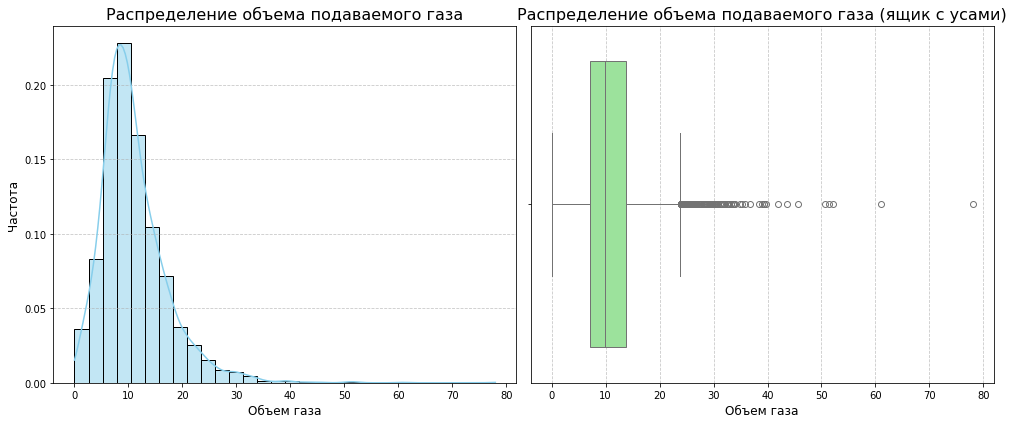

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Гистограмма объема подаваемого газа
sns.histplot(
    gas, 
    x='gas', 
    bins=30, 
    kde=True, 
    color='skyblue', 
    stat='probability', 
    ax=axes[0] 
)
axes[0].set_title('Распределение объема подаваемого газа', fontsize=16)
axes[0].set_xlabel('Объем газа', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)  

# Ящик с усами для объема подаваемого газа
sns.boxplot(
    data=gas, 
    x='gas', 
    color='lightgreen', 
    ax=axes[1] 
)
axes[1].set_title('Распределение объема подаваемого газа (ящик с усами)', 
                  fontsize=16)
axes[1].set_xlabel('Объем газа', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)  

plt.tight_layout()
plt.show()

**Вывод по датафрейму gas**

- Большинство значений объема газа сосредоточено в небольшом диапазоне (около 0–20).
- Распределение имеет моду около 10 и правостороннюю ассиметрию.
- В правой части графика присутствуют выбросы, указывающие на редкие высокие значения объема газа (например, около 60 и 80).
- Данные выбросы не являются ошибками измерения, их можно оставить, так как они отражают реальные условия процесса.


<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="temp_preproc">temp</h3>

Содержит целевой признак. Ранее было установлено почти 19% пропусков.

In [63]:
# Собираем номера key, где temperature NaN
missing_keys = temp.loc[temp['temperature'].isna(), 'key'].values.tolist()
missing_keys = list(set(missing_keys))
print(missing_keys)
print('Количество партий с пропусками в значениях температуры:', 
      len(missing_keys))

[2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 266

In [64]:
print('Количетсво значений температуры для партий с пропусками в измерениях', 
      temp['temperature'].loc[temp['key'].isin(missing_keys)].count())
temp.loc[temp['key'].isin(missing_keys)].head(10)


Количетсво значений температуры для партий с пропусками в измерениях 739


,key,measurement_time,temperature
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13931,2501,2019-08-10 14:41:14,1587.0
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN


Партии, в которых пропущен целевой признак имеет последовательные номера от 2500 и до конца датафрейма. В данном случае отсутсвие значение скорее всего указывает на неисправность оборудования, которое должно было призводить замер температуры.
Т.к данный признак является целевым, его восстановление не предтсавляется возможным. Несмотря на большой объем, строки с отсутсвующим значением конечной температуры удалим

In [65]:
print('Размер датасета до удаления:', temp.shape)
temp = temp.loc[~temp['key'].isin(missing_keys)]
print('Размер после удаления:', temp.shape)

Размер датасета до удаления: (18092, 3)
Размер после удаления: (13926, 3)


In [66]:
temp.isna().sum()

key                 0
measurement_time    0
temperature         0
dtype: int64

Пропуски отсутсвуют, теперь необходимо оставить только начальную и конечную температуру для каждой партии

In [67]:
temp.head(10)

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [68]:
temp_first = (temp.groupby('key')
              .first()
              .rename(columns={'temperature': 'temperature_start'})
              .drop(columns='measurement_time'))
temp_last = (temp.groupby('key')
             .last()
             .rename(columns={'temperature': 'temperature_end'})
             .drop(columns='measurement_time'))
temp = pd.merge(temp_first, temp_last, on='key', how='inner').reset_index()
temp.head()

,key,temperature_start,temperature_end
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


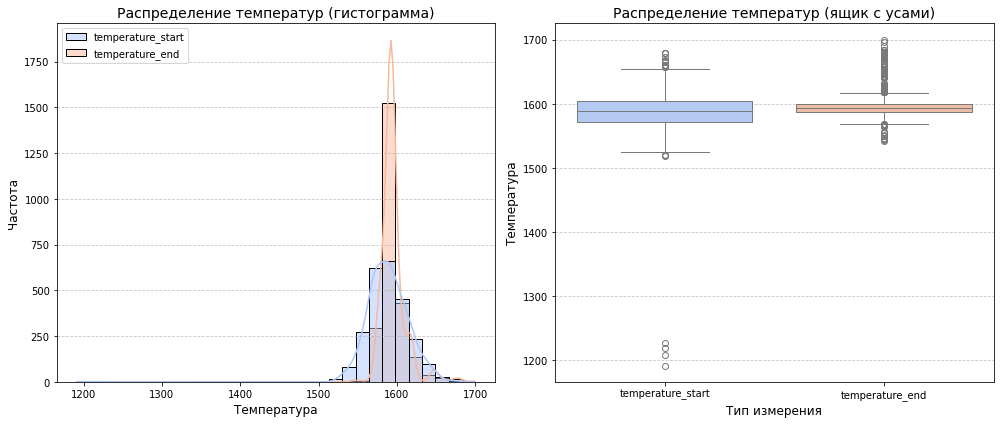

In [69]:
# Создание фигуры с двумя графиками в один ряд
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 строка, 2 столбца

# Гистограмма
sns.histplot(
    data=temp[['temperature_start','temperature_end']],
    
    bins=30,
    kde=True,          
    palette='coolwarm',    # Цветовая палитра
    ax=axes[0]         # Первая ось
)
axes[0].set_title('Распределение температур (гистограмма)', fontsize=14)
axes[0].set_xlabel('Температура', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем сетку

# Ящик с усами
sns.boxplot(
    data=temp[['temperature_start','temperature_end']],  
    palette='coolwarm',   # Цветовая палитра
    ax=axes[1]        # Вторая ось
)
axes[1].set_title('Распределение температур (ящик с усами)', fontsize=14)
axes[1].set_xlabel('Тип измерения', fontsize=12)
axes[1].set_ylabel('Температура', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем сетку

# Автоматическая настройка макета
plt.tight_layout()

# Отображение графиков
plt.show()

Гистограмма демонстрирует смещение распределения temperature_end вправо относительно temperature_start, что указывает на рост средней температуры. В boxplot медиана temperature_end выше, а IQR уже, что подтверждает устойчивый нагрев с уменьшением вариативности на финальном этапе.
Начальная температура содержит выбросы. Температура кристализации 1400 градусов по Цельсию, все что ниже удалим. 

In [70]:
print('Размер до удаления', temp.shape)
temp = temp.loc[temp['temperature_start'] > 1400]
print('Размер после удаления', temp.shape)

Размер до удаления (2477, 3)
Размер после удаления (2473, 3)


In [71]:
temp.describe()

,key,temperature_start,temperature_end
count,2473.000000,2473.000000,2473.000000
mean,1249.664375,1589.016175,1595.338051
std,720.395663,24.996127,16.031388
min,1.000000,1519.000000,1541.000000
25%,627.000000,1572.000000,1587.000000
50%,1251.000000,1588.000000,1593.000000
75%,1872.000000,1605.000000,1599.000000
max,2499.000000,1679.000000,1700.000000


**Выводы по датафрейму temp**

- Датафрейм содержит целевой признак. 
- Очищен от выбросов
- Начальная и конечная температура имеют вид нормального распределения (после удаления выбросов)
- Среднее значение целевого признака (температуры готовой стали) 1595, медиана 1593, стандартное отклонение 16 градусов.

<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="wire_preproc">wire</h3>

In [72]:
wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
wire_stat

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [74]:
wire = wire.fillna(0)
wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
wire['wire_total'] = wire.sum('columns')-wire['key']
wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


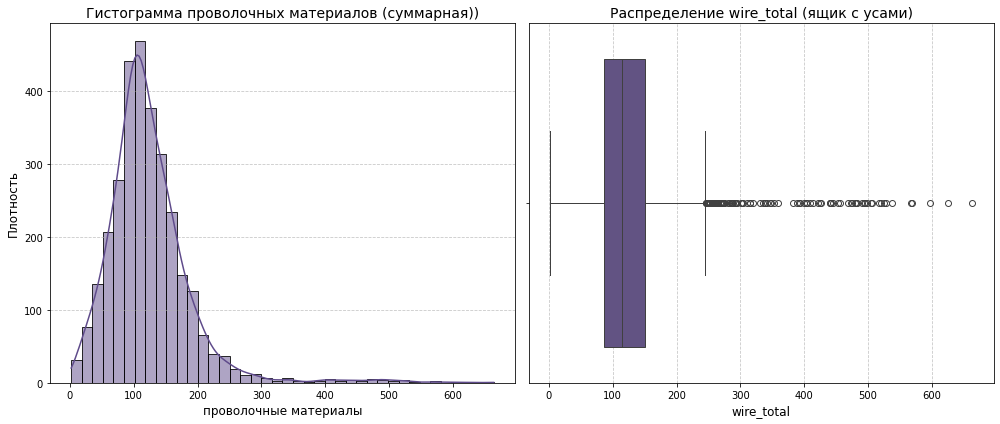

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
# Гистограмма wire_total
sns.histplot(
    wire, 
    x='wire_total', 
    bins=40, 
    kde=True, 
    color=pantone_colors['Ultra Violet'], 
    edgecolor='black', 
    ax=axes[0] 
)
axes[0].set_title('Гистограмма проволочных материалов (суммарная))', 
                  fontsize=14)
axes[0].set_xlabel('проволочные материалы', fontsize=12)
axes[0].set_ylabel('Плотность', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем сетку

# Ящик с усами для bulk_total
sns.boxplot(
    data=wire, 
    x='wire_total', 
    color=pantone_colors['Ultra Violet'], 
    ax=axes[1] 
)
axes[1].set_title('Распределение wire_total (ящик с усами)', fontsize=14)
axes[1].set_xlabel('wire_total', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7) 

plt.tight_layout()
plt.show()

На boxplot отмечены выбросы в правой части графика. Данные выбросы не являются ошибками измерения, их можно оставить, так как они отражают реальные условия процесса.

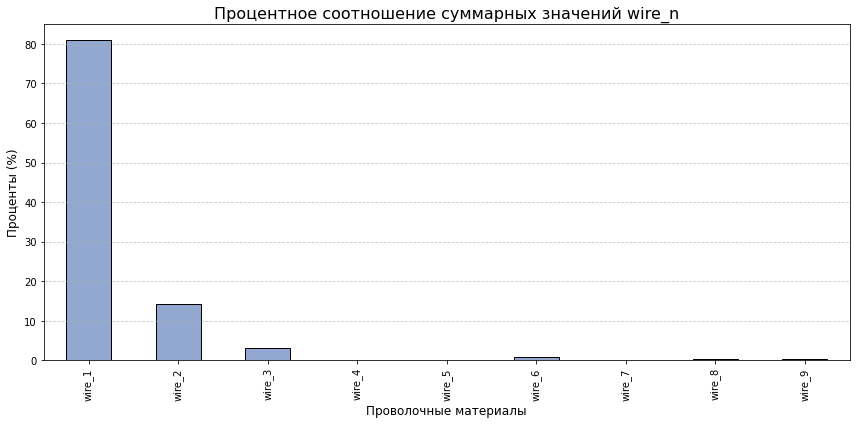

In [77]:
# Вычисление сумм для каждого bulk_n
sums = wire.iloc[:, 1:-1].sum()
# Нормализация значений в проценты
percentages = sums / sums.sum() * 100

plt.figure(figsize=(12, 6))
percentages.plot(kind='bar', 
                color=pantone_colors['Serenity'],
                edgecolor='black')
plt.title('Процентное соотношение суммарных значений wire_n', fontsize=16)
plt.xlabel('Проволочные материалы', fontsize=12)
plt.ylabel('Проценты (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Выводы по wire**

- Добавлен новый столбец признаков - суммарный объем проволочных материалов
- Пропуски заполнены
- На ящике с усами замечены аномалии, на данном этапе никак не обрабатывались.

<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="wire_time_preproc">wire_time</h3>

In [78]:
wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [79]:
# Применение функции для замены времени на очередность к каждой строке
wire_time.iloc[:, 1:] = wire_time.iloc[:, 1:].apply(replace_time_with_order, 
                                                    axis=1)

wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0
4,5,2,1,0,0,0,0,0,0,0


In [80]:

wire_time.columns = ([wire_time.columns[0]] + 
                     ['time_' + col for col in wire_time.columns[1:]])


Добавим столбец с количеством добавок в сплаве

In [81]:
wire_time['wire_count'] = wire_time.iloc[:, 1:].max(axis=1)
wire_time.head()

,key,time_wire_1,time_wire_2,time_wire_3,time_wire_4,time_wire_5,time_wire_6,time_wire_7,time_wire_8,time_wire_9,wire_count
0,1,1,0,0,0,0,0,0,0,0,1
1,2,1,0,0,0,0,0,0,0,0,1
2,3,1,0,0,0,0,0,0,0,0,1
3,4,1,0,0,0,0,0,0,0,0,1
4,5,2,1,0,0,0,0,0,0,0,2


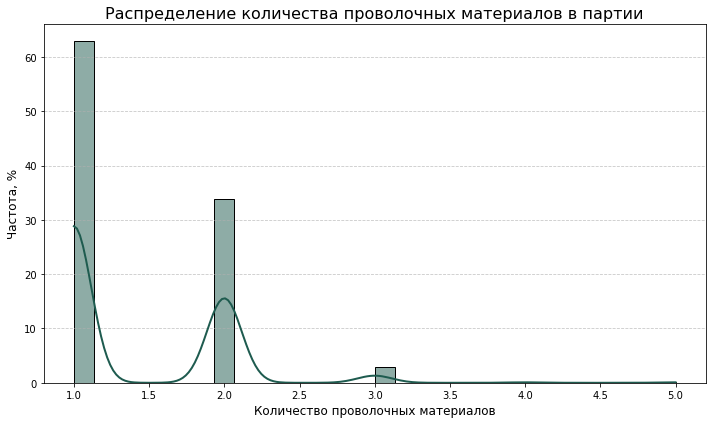

In [82]:
plt.figure(figsize=(10, 6))  
sns.histplot(
    data=wire_time,
    x='wire_count',
    bins=30,                  
    kde=True,                 
    color=pantone_colors['Lush Green'],      
    edgecolor='black',       
    line_kws={'linewidth': 2},
    stat='percent'
)

plt.title('Распределение количества проволочных материалов в партии', 
          fontsize=16)
plt.xlabel('Количество проволочных материалов', fontsize=12)
plt.ylabel('Частота, %', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Вывод по датасету wire_time**

- Пропуски заменены нулями.
- Время добавления проволочных материалов преобразовано в порядковые номера.
- Добавлен столбец с количеством разных добавок в каждой партии.
- Данные подготовлены для дальнейшего анализа.

<a href='#content'>Вернуться к оглавлению</a> 

<h2 id="data-merging">Объединение данных</h2>
    <p>Описывается процесс объединения нескольких датасетов в один для дальнейшего анализа.</p>

In [83]:
def merge_and_analyze(dataframes_dict):
    """
    Функция принимает на вход словарь с 
    названиями датафреймов и их содержимым,
    выполняет их внутреннее объединение (merge), 
    выводит размеры до и после объединения,
    а также процентное соотношение размера датафрейма 
    после объединения относительно исходного.
    
    """
    if len(dataframes_dict) < 2:
        raise ValueError("Функция требует минимум \
                         два датафрейма для объединения.")
    
    # Выводим размеры исходных датафреймов
    print("Размеры исходных датафреймов:")
    total_rows_before = 0
    for name, df in dataframes_dict.items():
        rows, cols = df.shape
        total_rows_before += rows
        print(f"{name}: {rows} строк, {cols} столбцов")
    
    # Выполняем последовательное внутреннее объединение датафреймов
    merged_df = None
    for name, df in dataframes_dict.items():
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, how='inner', on='key')
    
    # Выводим размер объединенного датафрейма
    rows_after, cols_after = merged_df.shape
    print("\nРазмер объединенного датафрейма:")
    print(f"Объединенный датафрейм: {rows_after} строк, \
           {cols_after} столбцов")
    
    # Вычисляем процентное соотношение
    percentage = (rows_after / total_rows_before) * 100
    print(f"Процент строк после объединения относительно исходных: \
          {percentage:.2f}%")
    
    return merged_df

In [84]:
dataframes_dict = {'arc_sum': arc_sum, 
                   'gas':gas, 
                   'temp':temp, 
                   'bulk':bulk, 
                   'bulk_time':bulk_time, 
                   'wire':wire, 
                   'wire_time':wire_time}

In [85]:
df = merge_and_analyze(dataframes_dict)

Размеры исходных датафреймов:
arc_sum: 3214 строк, 6 столбцов
gas: 3239 строк, 2 столбцов
temp: 2473 строк, 3 столбцов
bulk: 3129 строк, 17 столбцов
bulk_time: 3129 строк, 17 столбцов
wire: 3081 строк, 11 столбцов
wire_time: 3081 строк, 11 столбцов

Размер объединенного датафрейма:
Объединенный датафрейм: 2325 строк, 61 столбцов
Процент строк после объединения относительно исходных: 10.89%


<a href='#content'>Вернуться к оглавлению</a> 

<h2 id="merged-eda-preprocessing">Исследовательский анализ и предобработка данных объединённого датафрейма</h2>
    <p>Проводится углубленный анализ объединённого датафрейма, устраняются выявленные проблемы.</p>

In [86]:
df.head()

,key,active_power,reactive_power,duration,full_power,work,gas,temperature_start,temperature_end,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_total,time_bulk_1,time_bulk_2,time_bulk_3,time_bulk_4,time_bulk_5,time_bulk_6,time_bulk_7,time_bulk_8,time_bulk_9,time_bulk_10,time_bulk_11,time_bulk_12,time_bulk_13,time_bulk_14,time_bulk_15,bulk_count,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total,time_wire_1,time_wire_2,time_wire_3,time_wire_4,time_wire_5,time_wire_6,time_wire_7,time_wire_8,time_wire_9,wire_count
0,1,3.036730,2.142821,1098.0,3.718736,770.282114,29.749986,1571.0,1613.0,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,553,0,0,0,4,0,0,0,0,0,0,0,3,0,2,1,4,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,1,0,0,0,0,0,0,0,0,1
1,2,2.139408,1.453357,811.0,2.588349,481.760005,12.555561,1581.0,1602.0,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,582,0,0,0,1,0,0,0,0,0,0,0,4,0,3,2,4,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,1,0,0,0,0,0,0,0,0,1
2,3,4.063641,2.937457,655.0,5.019223,722.837668,28.554793,1596.0,1599.0,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,544,0,0,0,4,0,0,0,0,0,0,0,3,0,2,1,4,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,1,0,0,0,0,0,0,0,0,1
3,4,2.706489,2.056992,741.0,3.400038,683.455597,18.841219,1601.0,1625.0,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,595,0,0,0,1,0,0,0,0,0,0,0,4,0,3,2,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,1,0,0,0,0,0,0,0,0,1
4,5,2.252950,1.687991,869.0,2.816980,512.169934,5.413692,1576.0,1602.0,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,584,0,0,0,3,0,0,0,0,0,0,0,3,0,4,3,4,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2,1,0,0,0,0,0,0,0,2


In [87]:
df.describe()

,key,active_power,reactive_power,duration,full_power,work,gas,temperature_start,temperature_end,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_total,time_bulk_1,time_bulk_2,time_bulk_3,time_bulk_4,time_bulk_5,time_bulk_6,time_bulk_7,time_bulk_8,time_bulk_9,time_bulk_10,time_bulk_11,time_bulk_12,time_bulk_13,time_bulk_14,time_bulk_15,bulk_count,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total,time_wire_1,time_wire_2,time_wire_3,time_wire_4,time_wire_5,time_wire_6,time_wire_7,time_wire_8,time_wire_9,wire_count
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,3.125813,2.300941,807.988387,3.885528,670.060566,11.378942,1587.365161,1593.366022,3.433548,1.424946,47.296774,37.331613,2.644731,22.468817,2.008172,0.021075,0.445591,5.061505,4.252473,208.507957,1.069247,153.971613,120.026667,609.964731,0.305376,0.018925,1.265376,1.067097,0.073118,0.590968,0.011183,0.000860,0.015054,0.206022,0.185806,2.495914,0.015914,2.200430,1.227957,3.593978,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658,125.181774,1.383226,0.376344,0.029247,0.011183,0.0,0.021075,0.001720,0.005591,0.011613,1.396989
std,715.099053,1.220473,0.903664,340.888430,1.517546,319.565380,6.395632,23.623144,11.209581,12.421994,19.098442,75.228262,58.670377,22.421296,55.831097,30.702509,1.016213,6.225965,20.934742,22.534166,157.137873,14.247231,81.398153,84.674380,287.569669,1.090402,0.271389,1.762497,1.659678,0.512985,1.361508,0.175659,0.041478,0.218027,0.876229,0.821330,1.587008,0.213981,1.263924,1.136013,1.224168,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510,63.685486,0.576186,0.542393,0.262396,0.162951,0.0,0.155185,0.041451,0.074582,0.122169,0.564505
min,1.000000,0.267676,0.196228,57.000000,0.331897,33.430208,0.008399,1519.000000,1541.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.918800,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
25%,629.000000,2.295820,1.670519,581.000000,2.844193,457.872635,7.282948,1571.000000,1587.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,3.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,89.013596,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1255.000000,3.036303,2.225398,778.000000,3.769823,630.913482,10.100950,1587.000000,1593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,609.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,1.000000,4.000000,101.08799

Зависимосить температуры от 
1. активной мощности
2. реактивной мощности
3. длительности
4. полной мощности
5. работы 
6. тепературы начальной

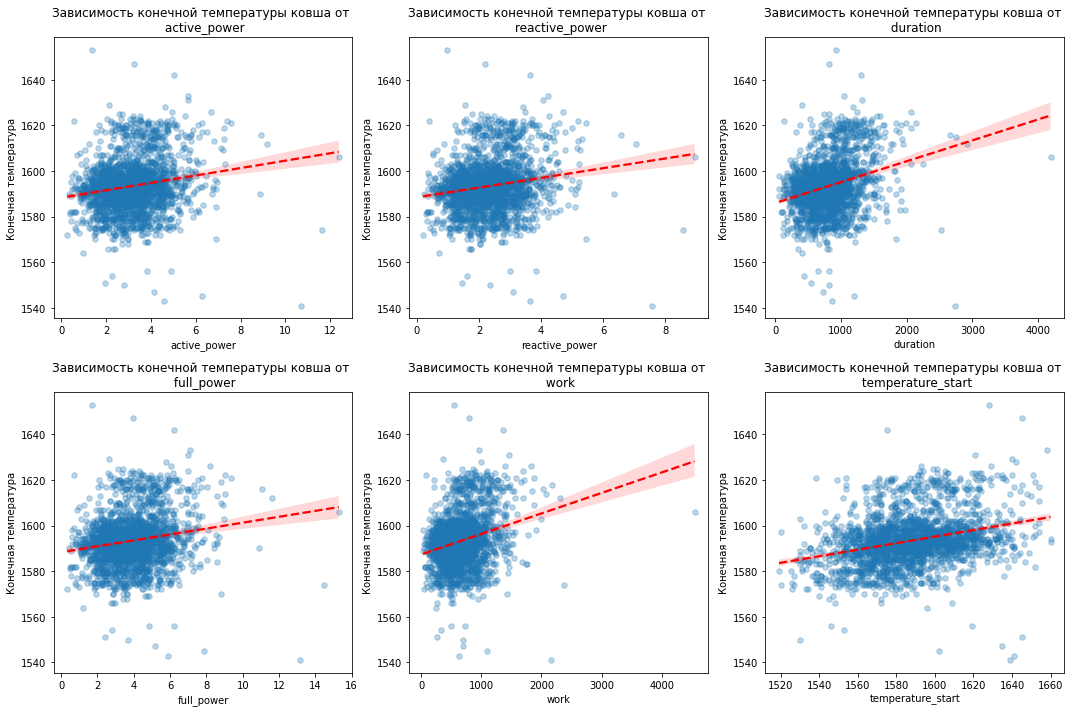

In [88]:
# Список переменных для построения scatterplot
variables = ['active_power', 
             'reactive_power', 
             'duration', 
             'full_power', 
             'work', 
             'temperature_start']

# Создаем subplot для каждого scatterplot
plt.figure(figsize=(15, 10))

for i, var in enumerate(variables):
    plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца
    
    # Scatterplot с линией тренда
    sns.regplot(x=var, y='temperature_end', data=df, 
                scatter_kws={'alpha': 0.3, 's': 30}, 
                line_kws={'color': 'red', 'linestyle': '--'})  
    # Заголовок и метки осей
    plt.title(f'Зависимость конечной температуры ковша от \n {var}')
    plt.xlabel(var)
    plt.ylabel('Конечная температура')

# Улучшаем компоновку графиков
plt.tight_layout()

# Отображаем графики
plt.show()

**Анализ графиков зависимости конечной температуры от начальной и факторов нагрева**

- Все графики имеют похожую форму. 
- Распределение точек показывает слабую положитеьлную корреляцию, хотя зависимость не является строго линейной. 
- Видны области с более высокой плотностью точек.

Необходимо провести корреляционный анализ для исключения мультиколлинеарности и дублирования признаков.

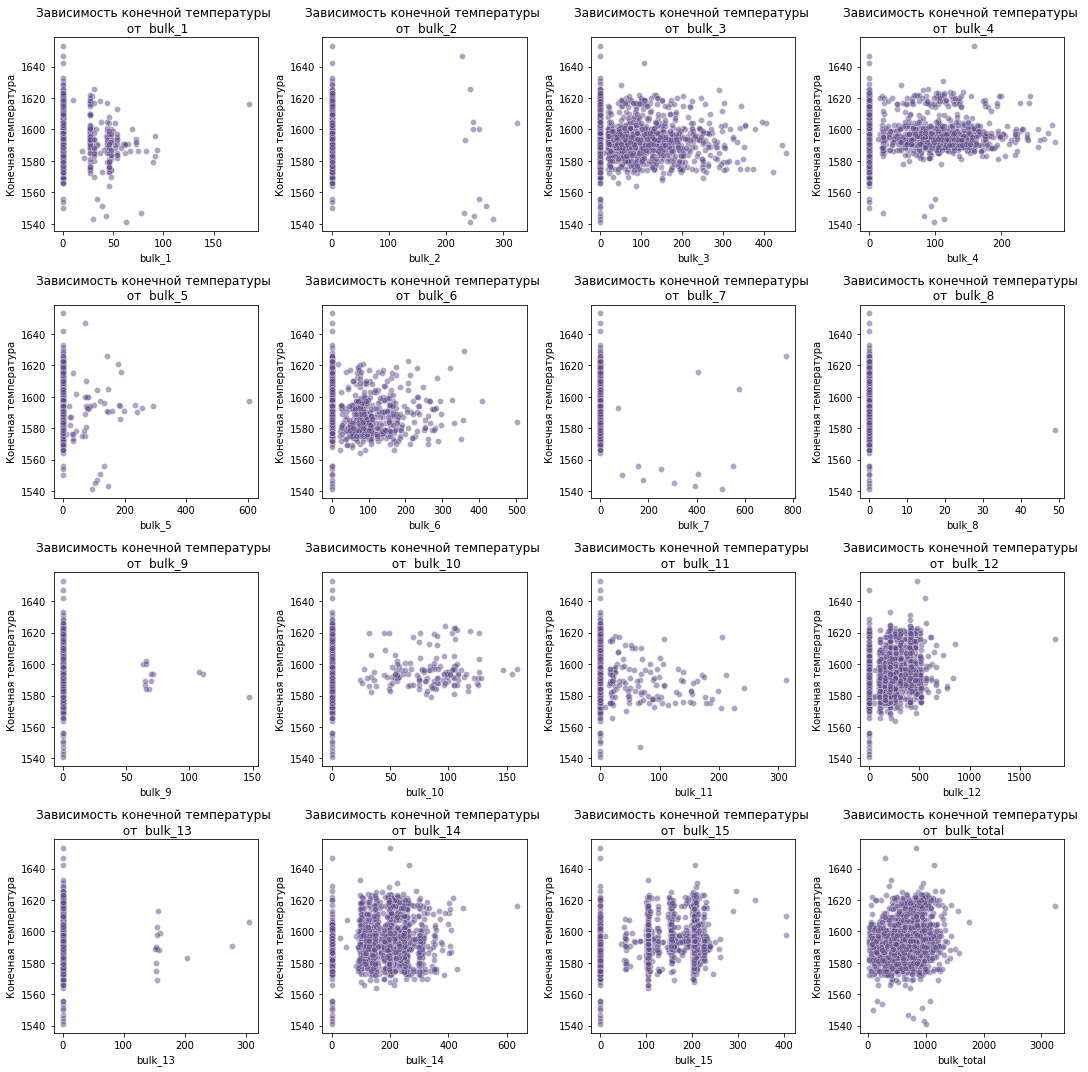

In [89]:
# Список переменных для построения scatterplot
variables = ['bulk_1',	'bulk_2',	'bulk_3',	'bulk_4',
            'bulk_5',	'bulk_6',	'bulk_7',	'bulk_8',
            'bulk_9',	'bulk_10',	'bulk_11',	'bulk_12',
            'bulk_13',	'bulk_14',	'bulk_15',	'bulk_total']

# Создаем subplot для каждого scatterplot
plt.figure(figsize=(15, 15))

for i, var in enumerate(df[variables]):
    plt.subplot(4, 4, i + 1)  # 2 строки, 3 столбца
    sns.scatterplot(x=var, 
                    y='temperature_end', 
                    data=df, 
                    alpha=0.5, 
                    color=pantone_colors['Ultra Violet'])
    plt.title(f'Зависимость конечной температуры \n от  {var}')
    plt.xlabel(var)
    plt.ylabel('Конечная температура')
plt.tight_layout()  
plt.show()

**Анализ графиков зависимости конесной температуры ковша от объема сыпучих материалов**

- Большинство параметров (bulk_2, bulk_5, bulk_7, bulk_8, bulk_9, bulk_13) демонстрируют слабую или отсутствующую корреляцию с конечной температурой ковша.
- Некоторые параметры (bulk_6, bulk_10, bulk_12, bulk_14, bulk_15, bulk_total) показывают слабую положительную корреляцию с конечной температурой ковша, но рассеивание точек остается значительным.
- Из всех параметров наиболее выраженную связь с конечной температурой ковша демонстрирует bulk_total. Это может указывать на то, что суммарное значение всех компонент (bulk_total) играет более важную роль, чем отдельные компоненты.

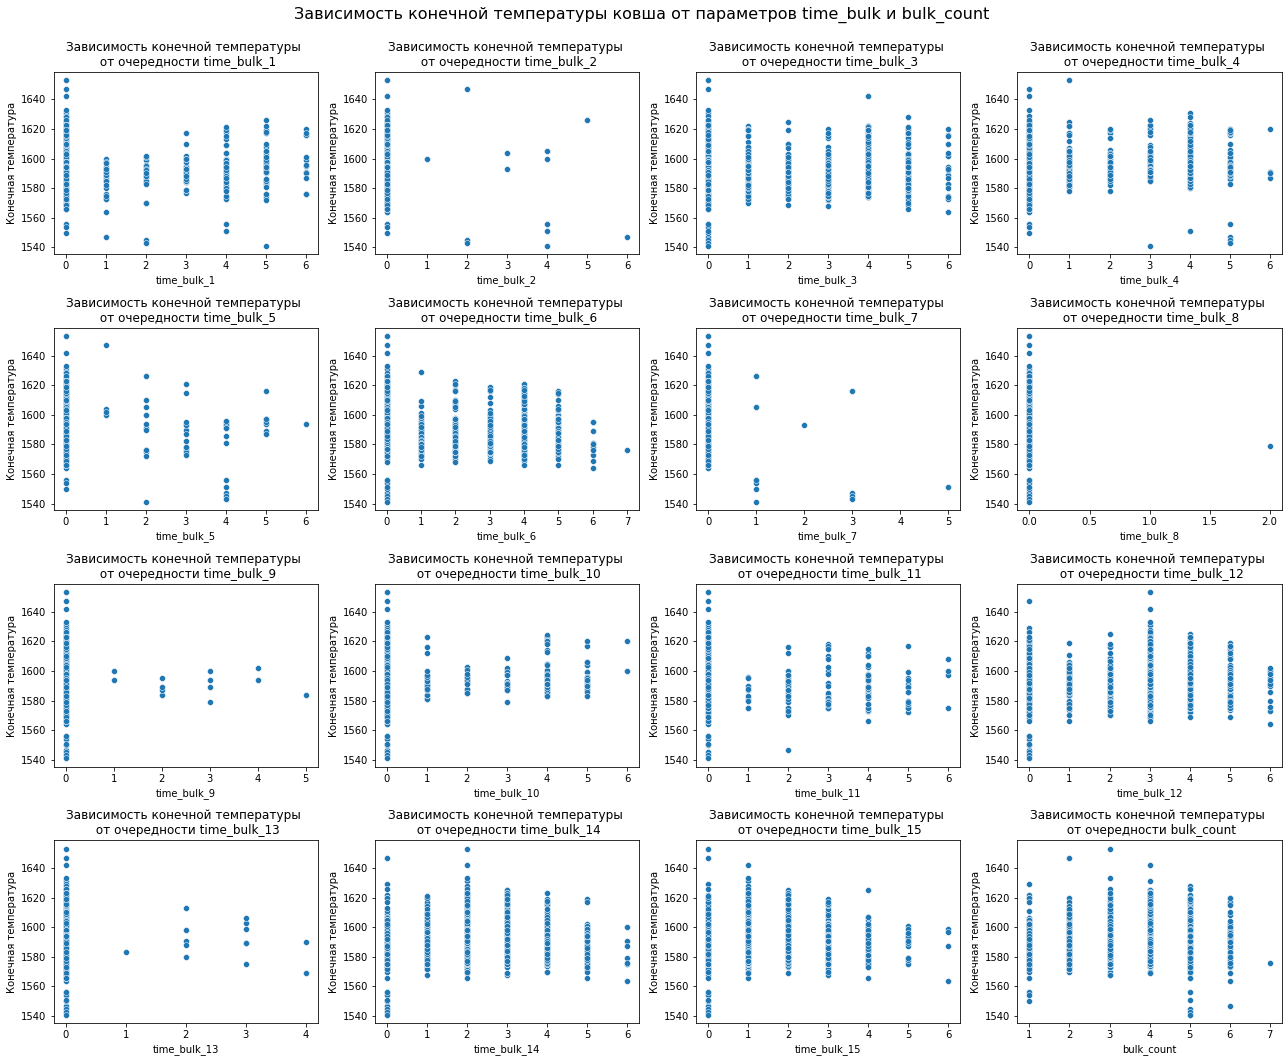

In [90]:
variables = ['time_bulk_1',	'time_bulk_2',	'time_bulk_3',	'time_bulk_4',
            'time_bulk_5',	'time_bulk_6',	'time_bulk_7',	'time_bulk_8',
            'time_bulk_9',	'time_bulk_10',	'time_bulk_11',	'time_bulk_12',
            'time_bulk_13',	'time_bulk_14',	'time_bulk_15',	'bulk_count']

plt.figure(figsize=(18, 15))
# Добавляем общее название для всей сетки графиков
plt.suptitle('Зависимость конечной температуры ковша от \
             параметров time_bulk и bulk_count \n', 
             fontsize=16)

for i, var in enumerate(df[variables]):
    plt.subplot(4, 4, i + 1)  # 2 строки, 3 столбца
    sns.scatterplot(x=var, y='temperature_end', data=df)
    plt.title(f'Зависимость конечной температуры \n от очередности {var}')
    plt.xlabel(var)
    plt.ylabel('Конечная температура')
plt.tight_layout()  
plt.show()

**Анализ графиков**
- Большинство параметров демонстрируют слабую или отсутствующую корреляцию с конечной температурой ковша.
- Наблюдается значительное рассеивание точек.
- Из всех параметров наиболее выраженную связь с конечной температурой ковша демонстрирует bulk_count. Это может указывать на то, что общее количество компонент (bulk_count) играет более важную роль, чем отдельные компоненты.

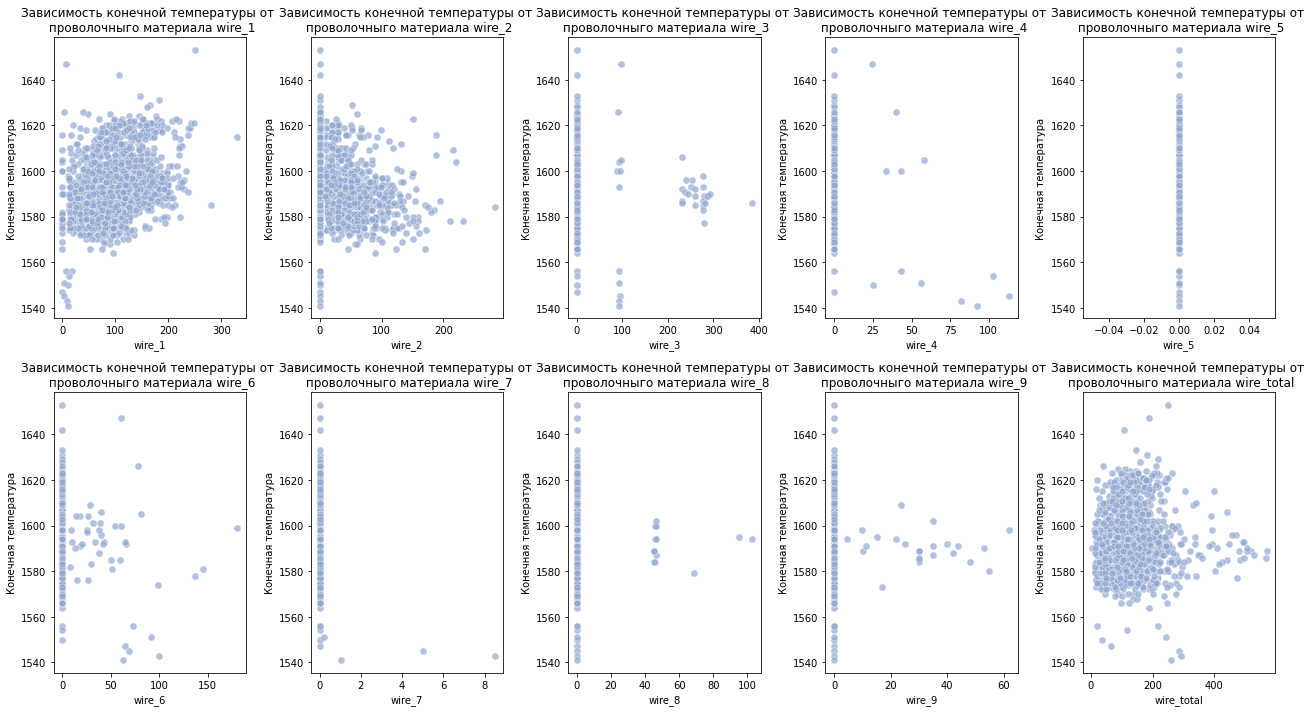

In [91]:
# Список переменных для построения scatterplot
variables = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
             'wire_6', 'wire_7', 'wire_8', 'wire_9', 'wire_total']

# Создаем subplot для каждого scatterplot
plt.figure(figsize=(18, 10))

for i, var in enumerate(df[variables]):
    plt.subplot(2, 5, i + 1)  # 2 строки, 3 столбца
    sns.scatterplot(x=var, 
                    y='temperature_end', 
                    data=df, 
                    color=pantone_colors['Serenity'], 
                    alpha=0.7, 
                    s=50)
    plt.title(f'Зависимость конечной температуры от \n \
               проволочныго материала {var}')
    plt.xlabel(var)
    plt.ylabel('Конечная температура')
plt.tight_layout()  
plt.show()

**Анализ графиков**
 - *wire_5* - не информативен (единтсвенное значение), может быть удален.
 -*wire_4, wire_7, wire_8, wire_9* - имеет слишком мало наблюдений отличных от нуля.
 - Из всех параметров наиболее выраженную связь с конечной температурой ковша демонстрирует wire_total. Это может указывать на то, что общее количество компонент (wire_total) играет более важную роль, чем отдельные компоненты.

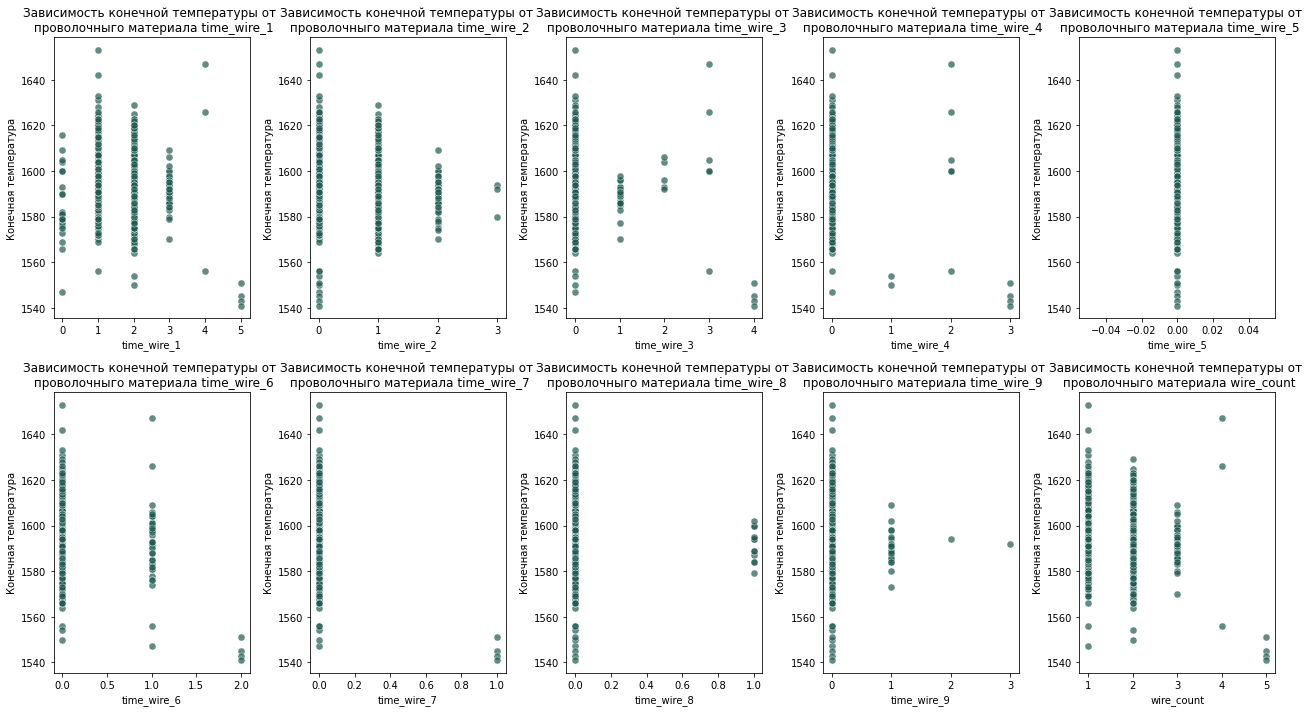

In [92]:
# Список переменных для построения scatterplot
variables = ['time_wire_1', 
             'time_wire_2', 
             'time_wire_3', 
             'time_wire_4', 
             'time_wire_5',
             'time_wire_6', 
             'time_wire_7', 
             'time_wire_8', 
             'time_wire_9', 
             'wire_count']

# Создаем subplot для каждого scatterplot
plt.figure(figsize=(18, 10))

for i, var in enumerate(df[variables]):
    plt.subplot(2, 5, i + 1)  # 2 строки, 3 столбца
    sns.scatterplot(x=var, 
                    y='temperature_end', 
                    data=df, 
                    color=pantone_colors['Lush Green'], 
                    alpha=0.7, 
                    s=50)
    plt.title(f'Зависимость конечной температуры от \n \
              проволочныго материала {var}')
    plt.xlabel(var)
    plt.ylabel('Конечная температура')
plt.tight_layout()  
plt.show()

**Анализ графиков time_wire (очередности добавления проволочного материала)**

- *time_wire_5* - неинформативен, единсвтенное значение нулевое. Можно удалить данный признак.
- *time_wire_8  и time_wire_9* - единственное значение отличное от нуля имеет широкий разброс значений конечной температуры.
- Из всех параметров наиболее выраженную связь с конечной температурой ковша демонстрирует wire_count. Это может указывать на то, что общее количество проволочного материала (wire_count) играет более важную роль, чем отдельные компоненты.


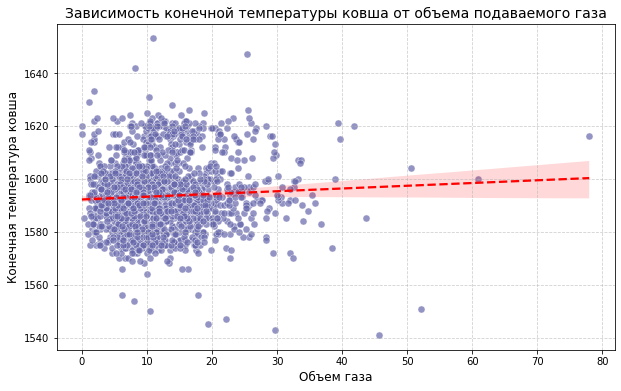

In [93]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='gas', y='temperature_end', 
               alpha=0.7,  
               s=50,       
               color=pantone_colors['Very Peri'])  

# Добавляем линию тренда
sns.regplot(data=df, x='gas', y='temperature_end', 
            scatter=False,  # Не показываем повторные точки
            color='red',     # Цвет линии тренда
            line_kws={'linestyle': '--'})  # Стиль линии

# Настройка заголовка и меток осей
plt.title('Зависимость конечной температуры ковша от объема подаваемого газа', 
          fontsize=14)
plt.xlabel('Объем газа', fontsize=12)
plt.ylabel('Конечная температура ковша', fontsize=12)

# Добавляем сетку
plt.grid(True, linestyle='--', alpha=0.6)

# Отображаем график
plt.show()

**Анализ графика зависимости конечной температуры от объема газа**

- Линия тренда имеет очень малый наклон, близкий к горизонтальной. Это указывает на слабую или отсутствующую положительную корреляцию между объемом газа и конечной температурой ковша.
- Высокое рассеяние точек вокруг линии тренда указывает на то, что другие факторы играют важную роль в определении конечной температуры ковша. 

<h3>Корреляционный анализ</h3>

In [ ]:
# Расчет матрицы корреляции Phi-K
phik_overview = phik_matrix(df, interval_cols=df.columns)

# Построение тепловой карты
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Correlation $\phi_K$',
    fontsize_factor=1.7,
    figsize=(50, 50)
)

**Промежуточные выводы**

Предположения, сделанные на основе графического анализа данных подтвердились: 
- У следующих признаков наблюдается отсутсвие корреляции с конечной температурой или очень мало значений отличных от нуля:
1. time_wire_5, time_wire_8, time_wire_9
2. wire_4, wire_5, wire_7, wire_8, wire_9, wire_10
3. time_bulk_8, time_bulk_9, time_bulk_13
4. bulk_1, bulk_2, bulk_3, bulk_5, bulk_7, bulk_8, bulk_9, bulk_10, bulk_13
Данные признаки удаляем из датасета.

wire_count, wire_total, bulk_count, bulk_total - получены путем сложения исходных признаков. Поэтому на карте корреляции наблюдается мультиколлинеарность. На основании показателей корреляции принято решение удалить:

5. time_wire (все, оставить только суммарный wire_count)
6. wire_total
7. time_bulk (все, оставим только суммарный bulk_count)
8. bulk_total 

Аналогично: 
- признак work получен путем перемножения duration  и full_power. Все три признака имеют схожую корреляцию. Уберем из конечного датасета work.
- full_power синтезирован из reactive_power  и active_power, но имеет чуть более высокую корреляцию, оставим full_power


In [95]:
df.columns

Index(['key', 'active_power', 'reactive_power', 'duration', 'full_power',
       'work', 'gas', 'temperature_start', 'temperature_end', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'bulk_total', 'time_bulk_1', 'time_bulk_2', 'time_bulk_3',
       'time_bulk_4', 'time_bulk_5', 'time_bulk_6', 'time_bulk_7',
       'time_bulk_8', 'time_bulk_9', 'time_bulk_10', 'time_bulk_11',
       'time_bulk_12', 'time_bulk_13', 'time_bulk_14', 'time_bulk_15',
       'bulk_count', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
       'wire_6', 'wire_7', 'wire_8', 'wire_9', 'wire_total', 'time_wire_1',
       'time_wire_2', 'time_wire_3', 'time_wire_4', 'time_wire_5',
       'time_wire_6', 'time_wire_7', 'time_wire_8', 'time_wire_9',
       'wire_count'],
      dtype='object')

In [96]:
print('Размер до удаления признаков:', df.shape)
df = df[['temperature_end', 'temperature_start', 
       'duration', 'full_power','gas', 
       'bulk_4', 'bulk_6', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 
       'bulk_count',
       'wire_1', 'wire_2', 'wire_3', 'wire_6', 
       'wire_count']]
print('Размер после удаления признаков:', df.shape)

Размер до удаления признаков: (2325, 61)
Размер после удаления признаков: (2325, 17)


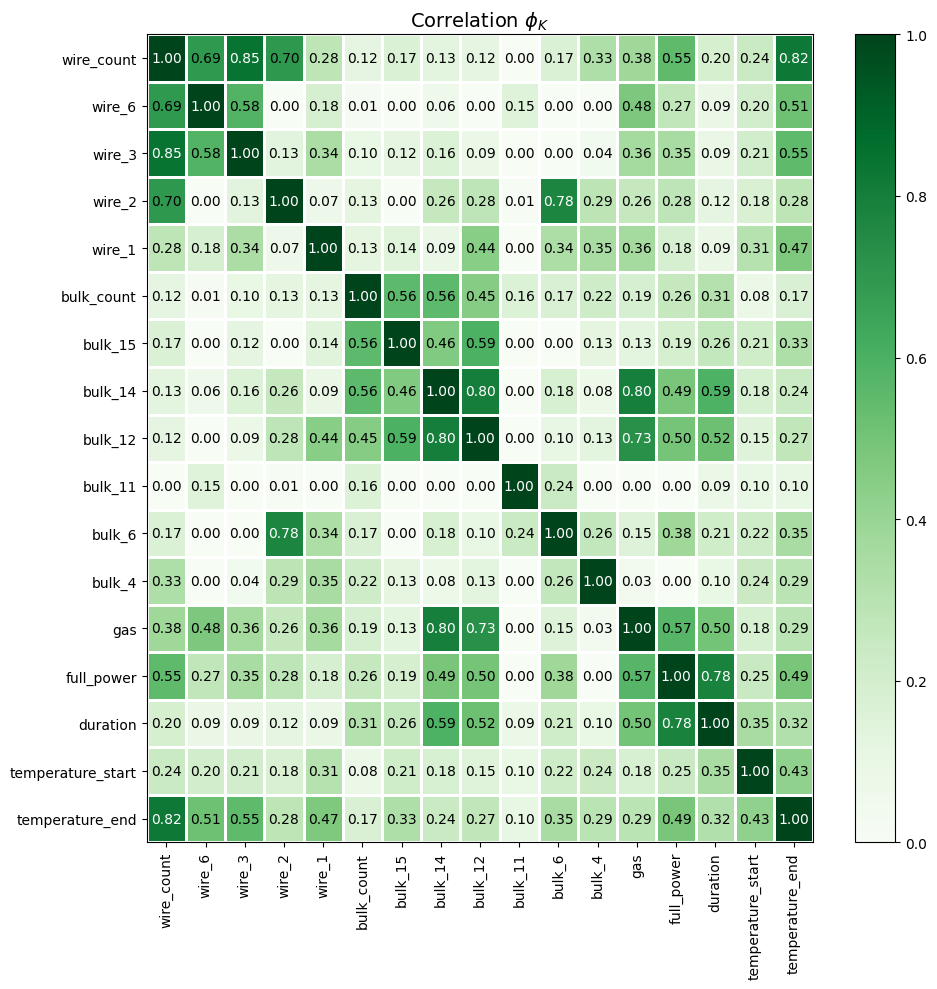

In [95]:
# Расчет матрицы корреляции Phi-K
phik_overview = phik_matrix(df, interval_cols=df.columns)

# Построение тепловой карты
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Correlation $\phi_K$',
    fontsize_factor=1.0,
    figsize=(10,10)
)

In [97]:
X = add_constant(df[df.columns])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
pd.set_option('display.max_rows', None)  
vif_data

,feature,VIF
0,const,27304.663555
1,temperature_end,1.700205
2,temperature_start,1.762045
3,duration,3.953922
4,full_power,2.303600
5,gas,1.387589
6,bulk_4,1.253836
7,bulk_6,1.361378
8,bulk_11,1.102074
9,bulk_12,2.478781


**Выводы**

- По результатам графического и корреляционного анализа были удалены признаки, не имеющие корреляции с целевым признаком. А также признаки имеющие слишком мало наблюдений.
- Данные проверены на мультиколлинеарность с помощью матрицы корреляции Phi-K (все значения ниже 0.9), а также с помощью коэффициента инфляции дисперсии (не превышает 5).
- Конечный датасет содержит 17 признаков, из которых 1 - целевой (конечная температура ковша) и 16 признаков для обучения модели.

<a href='#content'>Вернуться к оглавлению</a> 

<h2 id="data-preparation">Подготовка данных</h2>
Разделим датасет на тренировочную и тестовую выборки. 

In [110]:
df.shape

(2325, 17)

In [98]:
df.head()

,temperature_end,temperature_start,duration,full_power,gas,bulk_4,bulk_6,bulk_11,bulk_12,bulk_14,bulk_15,bulk_count,wire_1,wire_2,wire_3,wire_6,wire_count
0,1613.0,1571.0,1098.0,3.718736,29.749986,43,0,0,206,150,154,4,60.059998,0.00000,0.0,0.0,1
1,1602.0,1581.0,811.0,2.588349,12.555561,73,0,0,206,149,154,4,96.052315,0.00000,0.0,0.0,1
2,1599.0,1596.0,655.0,5.019223,28.554793,34,0,0,205,152,153,4,91.160157,0.00000,0.0,0.0,1
3,1625.0,1601.0,741.0,3.400038,18.841219,81,0,0,207,153,154,4,89.063515,0.00000,0.0,0.0,1
4,1602.0,1576.0,869.0,2.816980,5.413692,78,0,0,203,151,152,4,89.238236,9.11456,0.0,0.0,2


In [99]:
# создание константы RANDOM_STATE
RANDOM_STATE = 250325

X = df.drop('temperature_end', axis=1)
y = df['temperature_end']

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE
) 

# вывод необходимых размерностей
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1743, 16)
(582, 16)
(1743,)
(582,)


In [100]:
num_columns = X_train.columns
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [101]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)
 
X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)

In [102]:
X_test_p.head()

,num__temperature_start,num__duration,num__full_power,num__gas,num__bulk_4,num__bulk_6,num__bulk_11,num__bulk_12,num__bulk_14,num__bulk_15,num__bulk_count,num__wire_1,num__wire_2,num__wire_3,num__wire_6,num__wire_count
0,0.406922,-0.696712,-0.299667,-0.723309,0.298105,-0.417621,-0.190705,-0.016433,0.546985,0.974664,1.138378,0.372093,-0.525752,-0.124596,-0.114453,-0.697355
1,1.256289,0.838443,0.828044,1.982052,1.757887,-0.417621,-0.190705,0.688465,-0.051333,0.046805,0.321838,-0.340715,-0.525752,-0.124596,-0.114453,-0.697355
2,0.959011,0.593285,0.277152,0.930533,1.500278,-0.417621,-0.190705,1.626173,1.419533,0.375667,0.321838,1.136123,-0.525752,-0.124596,-0.114453,-0.697355
3,-0.654788,-0.118840,0.526128,0.359947,-0.629286,-0.417621,-0.190705,0.041770,-0.437747,-0.188096,0.321838,-0.017311,-0.525752,-0.124596,-0.114453,-0.697355
4,0.109643,-1.417592,-0.173110,-0.908672,-0.629286,-0.417621,-0.190705,-0.682529,1.955527,-1.433072,-1.311243,-0.730406,1.384388,-0.124596,-0.114453,1.024303


**Выводы**

1. Данные разделены на тестовую и обучающую выборку. 
2. Тестовая выборка составляет 25% от всего датасета. 
3. В обучающей выборке 1743 записи
4. В тестовой 582 записи
5. Обучение будет происходить на 16 признаках.
6. Тестовая выборка нормализована, обучающая будет масштабироваться перед обучением в пайплайне.

<a href='#content'>Вернуться к оглавлению</a> 

<h2 id="model-training">Обучение моделей машинного обучения и выбор лучшей модели</h2>
    

<h3 id="model-lr">Линейная регрессия</h3>
    <p>Начнем обучение с самой простой модели, линейной регрессии. Во время исследовательского анализа данных была установлена очень слабая линейная зависимость.</p>
    <p>Для нормализации данных будем использовать MinMaxScaler()</p>

In [103]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)
# Обучение модели через пайплайн
model_lr = pipe_final.fit(X_train, y_train)

# Получение предсказаний через кросс-валидацию
predict_lr = cross_val_score(model_lr, X_train, 
                             y_train, cv=5, 
                             scoring='neg_mean_absolute_error')

# Сохранение результатов в DataFrame
results_lr = pd.DataFrame({
    'MAE': -predict_lr
})

# Вывод результатов
print('Результыты обучения модели линейной регрессии')
display(results_lr)
print(f"Среднее значение MAE на обучающей выборке: {-predict_lr.mean():.2f}")
print(f"Стандартное отклонение: {results_lr['MAE'].std():.2f}")

Результыты обучения модели линейной регрессии


,MAE
0,6.413751
1,6.376649
2,6.827299
3,6.763582
4,6.776445


Среднее значение MAE на обучающей выборке: 6.63
Стандартное отклонение: 0.22


<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="model-tree">Ансамбль деревьев решений</h3>

In [104]:
param_grid = [
    {
        # название модели
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        # указываем гиперпараметры
        'models__n_estimators': [50, 10, 20],
        'models__max_depth': [10, 20, 30],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [2, 4, 6],
        'models__bootstrap': [True, False],
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    }
]


randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='neg_mean_absolute_error',  
    cv=5,  
    n_jobs=-1,  
    verbose=1,
    n_iter=20 
)

model_tree = randomized_search.fit(X_train, y_train)
# Лучшие параметры и результаты
print("Лучшие параметры:", model_tree.best_params_)
print(f"Лучший MAE: {-model_tree.best_score_:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'preprocessor__num': StandardScaler(), 'models__n_estimators': 50, 'models__min_samples_split': 2, 'models__min_samples_leaf': 4, 'models__max_depth': 10, 'models__bootstrap': True, 'models': RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=50,
                      random_state=250325)}
Лучший MAE: 6.55


In [105]:
result_tree = pd.DataFrame(model_tree.cv_results_)
result_tree.sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_estimators,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth,param_models__bootstrap,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.355090,0.076482,0.007127,0.000197,StandardScaler(),50,2,4,10,True,"RandomForestRegressor(max_depth=10, min_sample...","{'preprocessor__num': StandardScaler(), 'model...",-6.522186,-6.235730,-6.553967,-6.923918,-6.519552,-6.551071,0.219222,1
9,0.282513,0.004862,0.007129,0.000159,MinMaxScaler(),50,5,6,10,True,"RandomForestRegressor(max_depth=10, min_sample...","{'preprocessor__num': MinMaxScaler(), 'models_...",-6.474476,-6.289220,-6.591803,-6.972958,-6.506106,-6.566912,0.225764,2
10,0.138849,0.008938,0.005441,0.000354,StandardScaler(),20,5,4,20,True,"RandomForestRegressor(max_depth=10, min_sample...","{'preprocessor__num': StandardScaler(), 'model...",-6.692101,-6.222731,-6.581694,-7.011010,-6.383370,-6.578181,0.270047,3
0,0.155017,0.003382,0.005373,0.000123,StandardScaler(),20,5,2,20,True,"RandomForestRegressor(max_depth=10, min_sample...","{'preprocessor__num': StandardScaler(), 'model...",-6.798169,-6.299927,-6.510639,-6.891799,-6.463953,-6.592897,0.219410,4
7,0.116697,0.002032,0.005089,0.000634,StandardScaler(),20,10,6,10,True,"RandomForestRegressor(max_depth=10, min_sample...","{'preprocessor__num': StandardScaler(), 'model...",-6.492406,-6.299381,-6.654259,-7.076158,-6.515601,-6.607561,0.260175,5


<a href='#content'>Вернуться к оглавлению</a> 

<h3 id="model-catboost">Catboost</h3>

In [106]:
# Определение сетки гиперпараметров
param_grid = [
    {
    # название модели
    'models': [CatBoostRegressor(random_state=RANDOM_STATE,verbose=0 )],
    # указываем гиперпараметры
    'models__iterations': [500, 1000],  # Количество итераций (деревьев)
    'models__learning_rate': [0.01, 0.1],  # Скорость обучения
    'models__depth': [4, 6, 8],  # Глубина деревьев
    'models__l2_leaf_reg': [1, 3, 5],  # Коэффициент регуляризации L2
    'models__loss_function': ['MAE'],  # Функция потерь 
    'models__early_stopping_rounds': [50],  # Ранняя остановка
    'preprocessor__num':[StandardScaler(), MinMaxScaler(),'passthrough']
}
]

# Настройка GridSearchCV
catboost_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='neg_mean_absolute_error',  # Метрика для оптимизации
    cv=5,  # Количество фолдов для кросс-валидации
    n_jobs=-1,  # Использование всех ядер процессора
    verbose=0  # Вывод прогресса
)

# Обучение модели
catboost_search.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Лучшие параметры:", catboost_search.best_params_)
print(f"Лучший MAE: {-catboost_search.best_score_:.2f}")

Лучшие параметры: {'preprocessor__num': MinMaxScaler(), 'models__loss_function': 'MAE', 'models__learning_rate': 0.01, 'models__l2_leaf_reg': 5, 'models__iterations': 1000, 'models__early_stopping_rounds': 50, 'models__depth': 4, 'models': <catboost.core.CatBoostRegressor object at 0x7f921ae0baf0>}
Лучший MAE: 6.35


In [107]:
# Преобразование результатов в DataFrame
results_catboost = pd.DataFrame(catboost_search.cv_results_)

results_catboost.sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__loss_function,param_models__learning_rate,param_models__l2_leaf_reg,param_models__iterations,param_models__early_stopping_rounds,param_models__depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,2.048203,0.102166,0.004739,0.000390,MinMaxScaler(),MAE,0.01,5,1000,50,4,<catboost.core.CatBoostRegressor object at 0x7...,"{'preprocessor__num': MinMaxScaler(), 'models_...",-6.397618,-6.061447,-6.300921,-6.681300,-6.322690,-6.352795,0.199201,1
3,1.321417,0.043613,0.004586,0.000292,MinMaxScaler(),MAE,0.1,5,500,50,4,<catboost.core.CatBoostRegressor object at 0x7...,"{'preprocessor__num': MinMaxScaler(), 'models_...",-6.498825,-6.193453,-6.466148,-6.547677,-6.408293,-6.422879,0.123340,2
9,2.021517,0.052991,0.003429,0.000098,passthrough,MAE,0.1,1,1000,50,4,<catboost.core.CatBoostRegressor object at 0x7...,"{'preprocessor__num': 'passthrough', 'models__...",-6.480276,-6.244062,-6.443874,-6.683224,-6.308625,-6.432012,0.152399,3
0,2.165546,0.066725,0.004870,0.000800,MinMaxScaler(),MAE,0.01,1,500,50,6,<catboost.core.CatBoostRegressor object at 0x7...,"{'preprocessor__num': MinMaxScaler(), 'models_...",-6.505034,-6.072862,-6.477459,-6.853612,-6.346266,-6.451046,0.252853,4
8,4.746490,0.182067,0.004659,0.000245,MinMaxScaler(),MAE,0.01,1,500,50,8,<catboost.core.CatBoostRegressor object at 0x7...,"{'preprocessor__num': MinMaxScaler(), 'models_...",-6.506064,-6.075141,-6.561603,-6.866778,-6.350304,-6.471978,0.259748,5


**Выводы**

Лучшее значение метрики MAE получено на модели catboost c гиперпараметрами:
 - models__loss_function: 'MAE', 
 - models__learning_rate: 0.1, 
 - models__l2_leaf_reg: 5, 
 - models__iterations: 1000, 
 - models__early_stopping_rounds: 50,
 - models__depth: 4,

 Значение МAE при кроссвалидации на обучающей выборке составило 6.34


<a href='#content'>Вернуться к оглавлению</a> 

<h2 id=model-selection>Предсказание на тестовой выборке, анализ важности признаков<h2>

In [108]:
# Предсказание на тестовой выборке
y_pred = catboost_search.predict(X_test)

# Оценка качества модели
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE на тестовой выборке: {mae:.2f}")

MAE на тестовой выборке: 5.75


Результат на тестовой выборке удовлетворяет критериям.

<h3>Анализ важности признаков для предсказания с помощью библиотеки SHAP</h3>

In [108]:
# Извлекаем модель из пайплайна
best_model = catboost_search.best_estimator_.named_steps['models']

In [109]:
best_model

In [110]:
# Создание SHAP TreeExplainer
explainer = shap.TreeExplainer(best_model)

# Вычисление SHAP-значений
shap_values = explainer.shap_values(X_test)

SHAP Dependence Plot показывает влияние каждого признака на предсказания модели. 


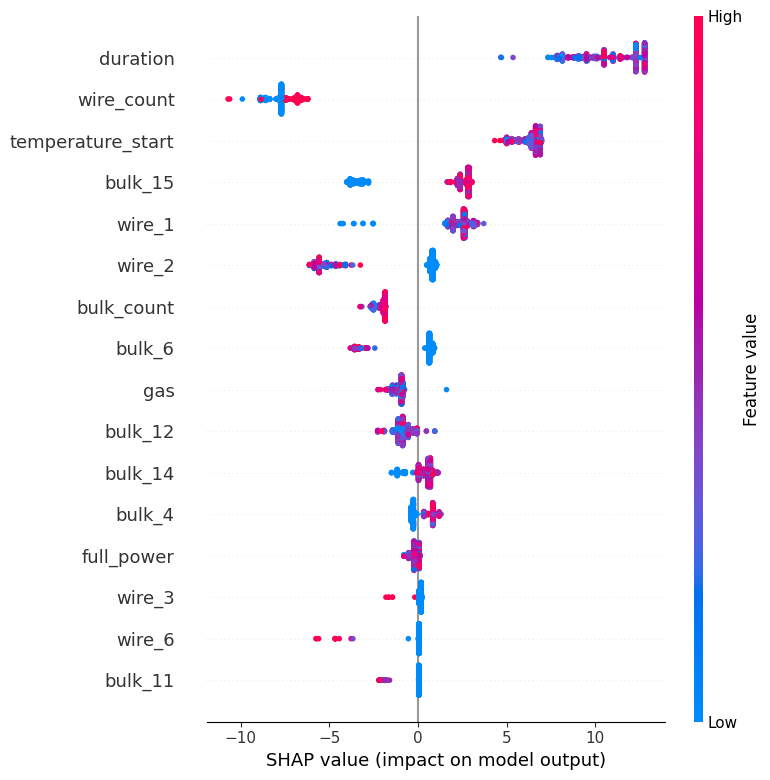

In [111]:
# Визуализация глобальной важности признаков
shap.summary_plot(shap_values, X_test)

1. По оси X : 
- Положительные значения SHAP означают, что признак увеличивает предсказание.
- Отрицательные значения SHAP означают, что признак уменьшает предсказание.
2. По оси Y : Названия признаков по степени вклада в модель (от более важных к менее важным)
3. Цветовая шкала : 
- Синий цвет: Низкие значения признака.
- Фиолетовый/красный цвет: Высокие значения признака.

**Интерпретация влияния признаков (топ-5)**
1. duration (длительность нагрева) увеличивает температуру предсказания модели. 
2. temperature_start (начальная температура) значения распределены по обеим сторонам оси X.
Признак temperature_start может как увеличивать, так и уменьшать предсказания модели в зависимости от его значения. Это указывает на сложную зависимость между temperature_start и конечной температурой.
3. gas (объем газа) уменьшает предсказания модели. Чем выше подаваемый объем газа, тем сильнее его негативное влияние на температуру.
4. bulk_14 в целом увеличивает предсказания модели. Высокие значения bulk_14 имеют более значительное позитивное влияние.
5. wire_1 в целом уменьшает предсказания модели. Чем выше значение wire_1, тем сильнее его негативное влияние.


**На основе SHAP-значений можно оценить относительную важность признаков:**

*Признаки с высоким позитивным влиянием :*
- duration, bulk_14, wire_2, bulk_12, bulk_count, bulk_4.

*Признаки с высоким негативным влиянием :*
- gas, wire_1, bulk_15, bulk_6, wire_6, full_power, bulk_11, wire_count, wire_3.


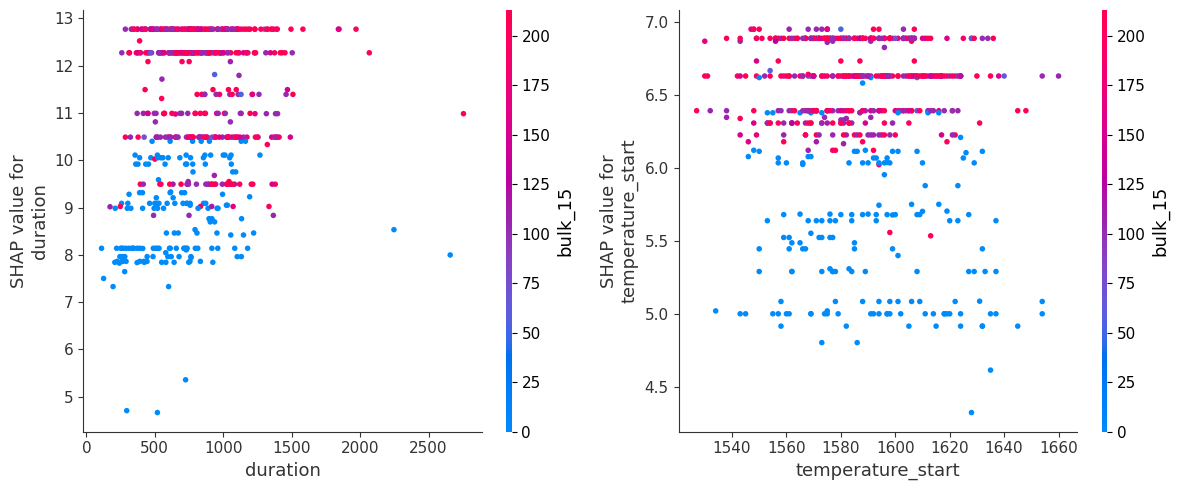

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
# Список признаков для построения графиков (топ-6 по вкладу в модель)
features = ["duration", "temperature_start"]

# Цикл для построения графиков
for i, feature in enumerate(features):
     
    col = i % 2  
    
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        ax=axes[col],  
        show=False  
    )
plt.tight_layout() 
plt.show()


 **График для признака `duration`**:
  - Зависимость нелинейная:
    - Для небольших значений `duration` (менее 500), SHAP-значения начинаются с низких значений (~12).
    - По мере роста `duration`, SHAP-значения также увеличиваются, но темп роста замедляется.
    - Для больших значений `duration` (>1500), SHAP-значения стабилизируются около ~18.
    - Низкие значения `bulk_6` (синий цвет) чаще связаны с более низкими SHAP-значениями.
    - Высокие значения `bulk_6` (фиолетовый/красный цвет) чаще связаны с более высокими SHAP-значениями.
  - Это указывает на **взаимосвязь между `duration` и `bulk_6`: при одинаковых значениях `duration`, SHAP-значения могут различаться в зависимости от значения `bulk_6`.

**График для признака `temperature_start`**:
  - Зависимость линейная или слабо нелинейная:
    - SHAP-значения изменяются примерно пропорционально изменениям в `temperature_start`.
    - Диапазон SHAP-значений шире для средних значений `temperature_start` (около 1560–1600).
  - Цветовая шкала показывает значения `wire_count`:
    - Низкие значения `wire_count` (синий цвет) чаще связаны с более низкими SHAP-значениями.
    - Высокие значения `wire_count` (фиолетовый/красный цвет) чаще связаны с более высокими SHAP-значениями.
  - Это указывает на **взаимосвязь между `temperature_start` и `wire_count`: при одинаковых значениях `temperature_start`, SHAP-значения могут различаться в зависимости от значения `wire_count`.



In [113]:
# Локальное объяснение для нескольких объектов тестовой выборки
shap.initjs()  # Инициализация JavaScript для визуализации
shap.force_plot(explainer.expected_value, shap_values[0, :], 
                X_test.iloc[0, :])


In [114]:
shap.force_plot(explainer.expected_value, shap_values[-1, :], 
                X_test.iloc[150, :])

**1. Первый график (Первый объект тестовой выборки)**:
- **Базовое значение**: `1.593`
- **Финальное предсказание**: `1,610.77`
- **Вклад признаков**:
  - **Положительные вклады**:
    - `bulk_15 = 210`
    - `wire_1 = 76.27`
    - `bulk_14 = 183`
    - `temperature_start = 1,607`
    - `duration = 973`

  - **Отрицательные вклады**: 
    - `bulk_6 = 120`
    - `gas = 24.51`
    - `bulk_12 = 311`

**2. Второй график (Последний объект тестовой выборки)**:
- **Базовое значение**: `1.593`
- **Финальное предсказание**: `1,625.72`
  - **Положительные вклады**:
    - `wire_1 = 82.21`
    - `bulk_15 = 0`
    - `bulk_14 = 157`
    - `temperature_start = 1,616`
    - `duration = 364`
  
  - **Отрицательные вклады**: 
    - `gas = 16.42`
    - `bulk_6 = 0`

**Основные выводы**:
   - Оба графика показывают, что большинство признаков имеют **положительный вклад** в предсказания модели.
   - Признаки, такие как `wire_1`, `bulk_14`, и `temperature_start`, играют ключевую роль в увеличении финального предсказания.
 

<a href='#content'>Вернуться к оглавлению</a> 

<h2 id="conclusion-recommendations">Общий вывод и рекомендации заказчику</h2>
   

### Общий вывод

В результате анализа данные были очищены от пропусков, удалены признаки, не имеющие корреляции с целевым признаком (конечной температурой ковша), а также признаки с малым количеством значимых наблюдений. Данные проверены на мультиколлинеарность, что позволило оставить 16 наиболее значимых признаков для обучения модели.

- Было обучено 3 модели с подбором гиперпараметров. Лучшие результаты показала модель **CatBoost** с гиперпараметрами, обеспечивающими значение **MAE = 5.99** на кросс-валидации и **6.38** на тестовой выборке.
- Анализ SHAP-значений выявил ключевые признаки, влияющие на предсказания: **duration**, **temperature_start**, **gas**, **bulk_14**, **wire_1** и другие. Основные выводы подтверждают важность продолжительности нагрева, начальной температуры и состава добавок для точного прогнозирования конечной температуры стали.

Таким образом, разработанная модель позволяет эффективно прогнозировать температуру стали в реальном времени, что способствует оптимизации технологического процесса, снижению энергозатрат и улучшению качества продукции. Внедрение модели станет важным шагом в цифровизации производства и переходе к более экологичной металлургии за счет рационального использования ресурсов. 


<head>
    <title>Рекомендации</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            margin: 20px;
        }
        h1 {
            color: #333;
        }
        ol {
            margin-left: 20px;
        }
        li {
            margin-bottom: 10px;
        }
        strong {
            color: #0056b3;
        }
    </style>
</head>
<body>
    <h1>Рекомендации:</h1>
    <ol>
        <li>
            <strong>Контроль длительности нагрева (duration):</strong>
            <p>
                Увеличение времени нагрева положительно влияет на конечную температуру, но нелинейно. После достижения определенного порога (например, 1500 секунд) вклад становится минимальным. Рекомендуется избегать чрезмерно длительного нагрева, чтобы снизить энергопотребление.
            </p>
        </li>
        <li>
            <strong>Использование газа (gas):</strong>
            <p>
                Высокий объем подаваемого газа оказывает негативное влияние на температуру. Рекомендуется минимизировать использование газа или оптимизировать его подачу для снижения энергозатрат.
            </p>
        </li>
        <li>
            <strong>Сыпучие добавки (bulk_14, bulk_6):</strong>
            <p>
                Добавление bulk_14 положительно влияет на температуру, в то время как bulk_6 имеет отрицательный эффект.
            </p>
        </li>
        <li>
            <strong>Регулярное обновление модели:</strong>
            <p>
                Производственные процессы могут меняться со временем. Рекомендуется периодически переобучать модель на новых данных для поддержания её актуальности.
            </p>
        </li>
        <li>
            <strong>Повышение качества данных:</strong>
            <p>
                Мониторинг редко используемых материалов: Признаки, связанные с редкими добавками (например, bulk_8, wire_9), были удалены из анализа. Однако их влияние на производство может быть значимым. Рекомендуется собирать больше данных о таких добавках для более глубокого анализа.
            </p>
        </li>
        <li>
            <strong>Снижение углеродного следа:</strong>
            <p>
                Оптимизация использования газа и электроэнергии позволит не только снизить затраты, но и уменьшить экологическое воздействие производства.
            </p>
        </li>
        <li>
            <strong>Мониторинг начальной температуры (temperature_start):</strong>
            <p>
                Начальная температура играет ключевую роль в процессе. Рекомендуется внедрить строгий контроль этой переменной перед началом каждого цикла.
            </p>
        </li>
    </ol>
</body>
</html>

<a href='#content'>Вернуться к оглавлению</a> 